# Анализ бизнес-показателей Яндекс.Афиши.

<div style="border:solid Green 2px; padding: 40px">
Перед нами данные Яндекс.Афиши с июня 2017 по конец мая 2018 года. Они включают в себя: информацию о посещениях сайта, выгрузку всех заказов за этот период и статистику рекламных расходов.

Наша задача - определить выгодные источники трафика и дать рекомендации о перераспределении маркетингового бюджета с целью снижения расходов.
    </div>

## Шаг 1. Знакомство с данными

Импортируем библиотеки и загрузим датасет.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import math
from math import factorial
from scipy import stats as st
import warnings
warnings.filterwarnings('ignore')

In [2]:
df_visits = pd.read_csv('/datasets/visits_log.csv')
df_orders = pd.read_csv('/datasets/orders_log.csv')
df_costs = pd.read_csv('/datasets/costs.csv')

Выведем общую информацию о датасетах с помощью функции.

In [3]:
def display_data(data,name):
    print('*** Информация о датасете',name,'***')
    print()
    data.info()
    display(data.describe())
    display(data.sample(n=5)) 
    print('-----------------------------------------------------------------------------')
    print()
    
display_data(df_visits,'df_visits')
display_data(df_orders,'df_orders')
display_data(df_costs,'df_costs')

*** Информация о датасете df_visits ***

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


,Source Id,Uid
count,359400.000000,3.594000e+05
mean,3.750515,9.202557e+18
std,1.917116,5.298433e+18
min,1.000000,1.186350e+13
25%,3.000000,4.613407e+18
50%,4.000000,9.227413e+18
75%,5.000000,1.372824e+19
max,10.000000,1.844668e+19


,Device,End Ts,Source Id,Start Ts,Uid
321310,desktop,2017-10-08 14:23:00,4,2017-10-08 14:10:00,11774326625731857646
42141,desktop,2018-03-25 15:36:00,5,2018-03-25 15:12:00,9607619723159604835
51001,desktop,2018-01-06 04:00:00,5,2018-01-06 03:58:00,4639954538700773736
8077,desktop,2017-10-07 12:54:00,3,2017-10-07 12:30:00,16607142603985918845
278405,desktop,2017-12-21 09:29:00,3,2017-12-21 09:03:00,5722221302019989991


-----------------------------------------------------------------------------

*** Информация о датасете df_orders ***

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


,Revenue,Uid
count,50415.000000,5.041500e+04
mean,4.999647,9.098161e+18
std,21.818359,5.285742e+18
min,0.000000,3.135781e+14
25%,1.220000,4.533567e+18
50%,2.500000,9.102274e+18
75%,4.890000,1.368290e+19
max,2633.280000,1.844617e+19


,Buy Ts,Revenue,Uid
6508,2017-08-31 20:22:00,7.33,10652819822250312312
24094,2017-12-14 18:32:00,0.98,9858075846923182866
25958,2017-12-25 15:40:00,0.61,8753906061052874941
21153,2017-11-30 17:01:00,0.58,2277952639655176296
36401,2018-02-22 14:48:00,8.25,7764233344866164763


-----------------------------------------------------------------------------

*** Информация о датасете df_costs ***

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


,source_id,costs
count,2542.000000,2542.000000
mean,4.857199,129.477427
std,3.181581,156.296628
min,1.000000,0.540000
25%,2.000000,21.945000
50%,4.000000,77.295000
75%,9.000000,170.065000
max,10.000000,1788.280000


,source_id,dt,costs
695,2,2018-05-01,41.31
62,1,2017-08-02,25.47
462,2,2017-09-08,98.74
1551,5,2017-09-08,142.40
1173,4,2017-08-24,45.19


-----------------------------------------------------------------------------



### Вывод

1. названия столбцов нужно привести к нижнему регистру и убрать пробелы
2. столбцы dt и uid переименуем
3. данные об источниках трафика зашифрованы, есть только source_id (номера 1-10)
4. нужна замена типа данных для столбцов с датой
5. пропусков и отрицательных значений нет
6. аномальных значений пока не обнаружено
7. нулевые значения выручки в датасете df_orders

## Шаг 2. Подготовка данных

Поменяем названия столбцов для удобства обращения к ним.

In [4]:
df_visits.columns = ['device', 'end_ts', 'source_id', 'start_ts', 'user_id']
df_orders.columns = ['buy_ts', 'revenue', 'user_id']
df_costs.columns = ['source_id', 'date', 'costs']

Поменяем тип данных для столбцов с датой.

In [5]:
df_visits['end_ts'] = pd.to_datetime(df_visits['end_ts'])
df_visits['start_ts'] = pd.to_datetime(df_visits['start_ts'])
df_orders['buy_ts'] = pd.to_datetime(df_orders['buy_ts'])
df_costs['date'] = pd.to_datetime(df_costs['date'])

Посмотрим на нулевые значения выручки в датасете df_orders.

In [6]:
df_orders_zero = df_orders.query('revenue == 0')
print(len(df_orders_zero))
display(df_orders_zero.sample(5))

51


,buy_ts,revenue,user_id
21938,2017-12-04 22:08:00,0.0,6538135401269860305
21158,2017-11-30 17:26:00,0.0,2037345392173160982
21203,2017-11-30 20:24:00,0.0,9971607959588724150
21386,2017-12-01 16:37:00,0.0,2037345392173160982
45084,2018-04-22 18:38:00,0.0,5570343171257035973


In [7]:
display(df_orders_zero['user_id'].value_counts())

2037345392173160982     12
5603453646174104178      6
8277558335454815700      6
5570343171257035973      4
4927261749585088199      4
2883839899480223178      2
13486014841579728464     1
14973814017160376581     1
13594493436687104785     1
10281425020415612933     1
1149062814762747892      1
6538135401269860305      1
10169885790465067808     1
184148767273119549       1
5342067285161169772      1
2636645662067512510      1
14872085179275033073     1
17030528792926543083     1
15254206642996645755     1
1879819502567241225      1
9971607959588724150      1
12296506984642158789     1
2936104404423239931      1
Name: user_id, dtype: int64

In [8]:
display(df_orders.query('user_id == "2037345392173160982"'))

,buy_ts,revenue,user_id
20783,2017-11-28 19:42:00,0.00,2037345392173160982
21158,2017-11-30 17:26:00,0.00,2037345392173160982
21180,2017-11-30 18:30:00,0.00,2037345392173160982
21201,2017-11-30 20:05:00,0.00,2037345392173160982
21220,2017-11-30 21:34:00,0.00,2037345392173160982
21222,2017-11-30 21:49:00,0.00,2037345392173160982
21351,2017-12-01 14:59:00,0.00,2037345392173160982
21386,2017-12-01 16:37:00,0.00,2037345392173160982
21418,2017-12-01 19:10:00,0.00,2037345392173160982
21453,2017-12-01 23:07:00,2.93,2037345392173160982


Найдена 51 строка с нулевым значением выручки. Это всего лишь тысячная часть от всего датасета.
Чтобы не искажать дальнейшие расчёты мы удалили эти строки.

In [9]:
df_orders_1 = df_orders.query('revenue != 0')
print(len(df_orders_1))

50364


Проверим датасеты на дубликаты.

In [10]:
print('Количество дубликатов df_visits',df_visits.duplicated().sum())
print('Количество дубликатов df_orders_1',df_orders_1.duplicated().sum())
print('Количество дубликатов df_costs',df_costs.duplicated().sum())       

Количество дубликатов df_visits 0
Количество дубликатов df_orders_1 0
Количество дубликатов df_costs 0


### Вывод

Для удобства использования переименованы столбцы.

Данные о датах приведены к типу datetime, чтобы применять к этим данным специальные методы.

Нулевые продажи зафиксированы в разное время у разных пользователей. Но есть один пользователь, который встречается 12 раз в период с 28.11.17 по 02.12.17. В этот период обычно проходят акции "черная пятница". Возможно, были сбои платежной системы из-за большого наплыва клиентов. 

## Шаг 3. Расчетные метрики 

### Продуктовые метрики

#### DAU, WAU и MAU

Чтобы посчитать недельное и месячное использование, выделим в отдельные столбцы год, месяц, неделю, а также полную дату.

In [11]:
df_visits['session_year_number']  = df_visits['start_ts'].dt.year
df_visits['session_month_number'] = df_visits['start_ts'].dt.month
df_visits['session_week_number']  = df_visits['start_ts'].dt.week
df_visits['session_date'] = df_visits['start_ts'].dt.date
display(df_visits.head()) 

,device,end_ts,source_id,start_ts,user_id,session_year_number,session_month_number,session_week_number,session_date
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,12,51,2017-12-20
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2,8,2018-02-19
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,7,26,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,5,20,2018-05-20
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017,12,52,2017-12-27


Посчитаем метрики DAU, WAU и MAU. Сгруппируем данные по устройствам и найдём среднее.

In [12]:
dau_total = df_visits.pivot_table(index='session_date',columns='device',\
                                   values='user_id',aggfunc='nunique')
wau_total = df_visits.pivot_table(index=['session_year_number', 'session_week_number'],\
                                   columns='device',values='user_id',aggfunc='nunique')
mau_total = df_visits.pivot_table(index=['session_year_number', 'session_month_number'],\
                                   columns='device',values='user_id',aggfunc='nunique')
wau_total_mean = df_visits.groupby(['session_year_number', 'session_week_number'])\
            .agg({'user_id': 'nunique'})
mau_total_mean = df_visits.groupby(['session_year_number','session_month_number'])\
            .agg({'user_id': 'nunique'})

print('Среднее количество уникальных пользователей в день:', 
        round((df_visits.groupby('session_date').agg({'user_id': 'nunique'}).mean())))
print('Среднее количество уникальных пользователей в неделю:', 
        round(wau_total_mean.mean())) 
print('Среднее количество уникальных пользователей в месяц:', 
        round(mau_total_mean.mean())) 

Среднее количество уникальных пользователей в день: user_id    908.0
dtype: float64
Среднее количество уникальных пользователей в неделю: user_id    5716.0
dtype: float64
Среднее количество уникальных пользователей в месяц: user_id    23228.0
dtype: float64


Напишем функцию для построения графиков.

In [13]:
def my_plot(data, title, x, y):
    data.plot(figsize=(12,6));
    plt.title(title);
    plt.xlabel(x);
    plt.ylabel(y);
    plt.grid()

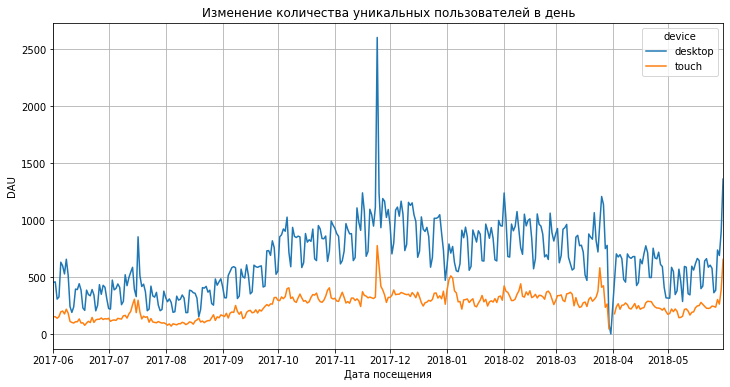

In [14]:
my_plot(dau_total,
        'Изменение количества уникальных пользователей в день',
        'Дата посещения', 'DAU')

In [15]:
dau_total_mean = dau_total.mean(axis=0)
print('Среднее количество уникальных пользователей в день для каждого типа устройства',
        round(dau_total_mean))

Среднее количество уникальных пользователей в день для каждого типа устройства device
desktop    659.0
touch      253.0
dtype: float64


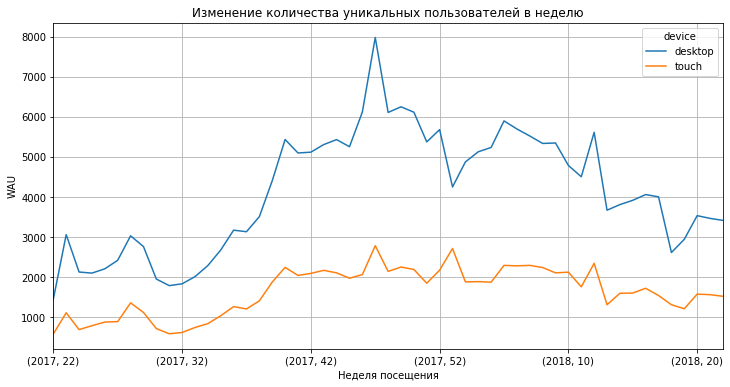

In [16]:
my_plot(wau_total,
        'Изменение количества уникальных пользователей в неделю',
        'Неделя посещения', 'WAU')

In [17]:
wau_total_mean_ = wau_total.mean(axis=0)
print('Среднее количество уникальных пользователей в неделю для каждого типа устройства',
      round(wau_total_mean_))

Среднее количество уникальных пользователей в неделю для каждого типа устройства device
desktop    4130.0
touch      1635.0
dtype: float64


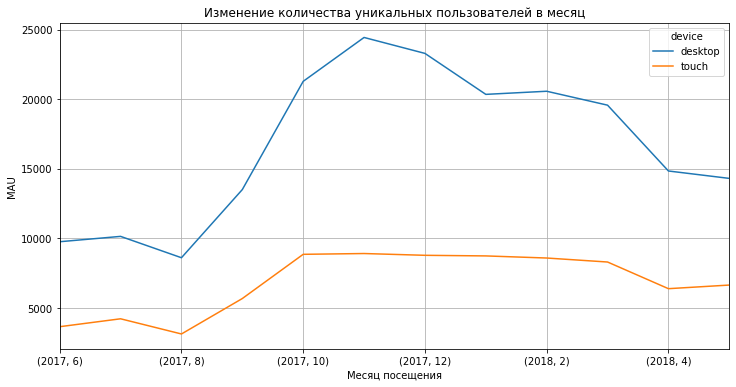

In [18]:
my_plot(mau_total,
        'Изменение количества уникальных пользователей в месяц',
        'Месяц посещения', 'MAU')

In [19]:
mau_total_mean_ = mau_total.mean(axis=0)
print('Среднее количество уникальных пользователей в месяц для каждого типа устройства',
      round(mau_total_mean_))

Среднее количество уникальных пользователей в месяц для каждого типа устройства device
desktop    16725.0
touch       6826.0
dtype: float64


Посчитаем sticky factor в процентах. 

In [20]:
sticky_wau = dau_total.mean() / wau_total.mean() * 100
sticky_mau = dau_total.mean() / mau_total.mean() * 100

print(round(sticky_wau))
print(round(sticky_mau))

device
desktop    16.0
touch      15.0
dtype: float64
device
desktop    4.0
touch      4.0
dtype: float64


Мы видим, что каждый день на сайт заходит в среднем 907 уникальных пользователей, в неделю их в среднем - 5716, а в месяц - 23228.

Sticky factor (фактор липкости) показывает регулярность посещения сайта - то, как часто пользователи к нему обращаются, характеризует лояльность и активность аудитории.

У Яндекс.Афиши значения этого фактора для недели и месяца минимальны, значит, пользователи редко возвращаются на сайт.
Нужно обратить на это внимание и озаботиться удержанием аудитории.

На графиках изменения количества пользователей по времени заметна сезонность, летом количество уникальных пользователей снижается, самый низкий месяц - август. Пик приходится на конец ноября, на период "черных пятниц".

На графике изменения дневного количества пользователей есть резкое падение в конце марта, возможно в это время велись технические работы на сайте.

Анализ типа устройства показывает, что аудитория ПК-версии сайта в 2.5 раза больше, чем мобильной. При этом графики изменения во времени очень похожи, значит пользователи ведут себя одинаково, независимо от типа устройства.

#### Количество сессий в день

In [21]:
cnt_session_day_ = df_visits.pivot_table(index='session_date',\
                 columns='device',values='user_id',aggfunc='count')
print('Среднее количество сессий в день для каждого типа устройства:', 
        round(cnt_session_day_.mean())) 

Среднее количество сессий в день для каждого типа устройства: device
desktop    721.0
touch      267.0
dtype: float64


In [22]:
cnt_session_day = df_visits.groupby('session_date')\
            .agg({'user_id': 'count'})
print('Среднее количество сессий в день:', 
        int(cnt_session_day.mean())) 

Среднее количество сессий в день: 987


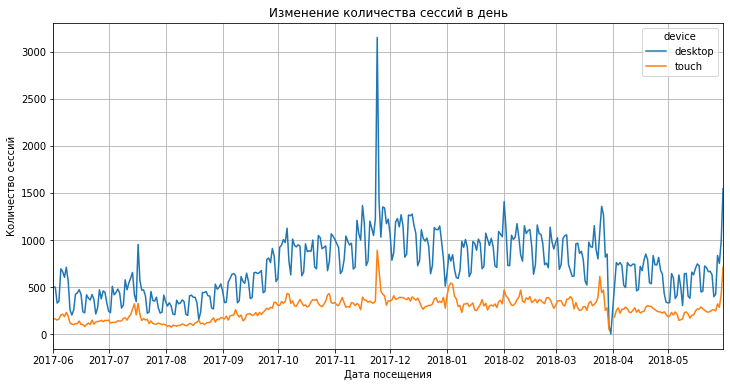

In [23]:
my_plot(cnt_session_day_,'Изменение количества сессий в день',
        'Дата посещения', 'Количество сессий')

Среднее количество сессий в день - 987, при этом количество уникальных пользователей в день - 907. Значит каждый пользователь совершает в среднем чуть больше одной сессии в день. Если он при этом успевает совершить покупку, то это неплохо. 

График изменения количества сессий в день похож на график изменения количества уникальных пользователей, что логично.

Количество сессий для ПК в 2.7 раз больше, чем количетсво сессий для мобильных устройств.

Теперь посчитаем среднее количество сессий в день для каждого пользователя.

In [24]:
cnt_session_day_user_ = df_visits.pivot_table(index=['session_date','user_id'],\
                 columns='device',values='start_ts',aggfunc='count')
print('Среднее количество сессий в день для каждого пользователя для каждого типа устройства:', 
        round(cnt_session_day_user_.mean())) 

Среднее количество сессий в день для каждого пользователя для каждого типа устройства: device
desktop    1.0
touch      1.0
dtype: float64


In [25]:
cnt_session_day_user = df_visits.groupby(['session_date','user_id'])\
            .agg({'start_ts': 'count'})
print('Среднее количество сессий в день для каждого пользователя:', 
        int(cnt_session_day_user.mean())) 

Среднее количество сессий в день для каждого пользователя: 1


In [26]:
sessions_per_user = cnt_session_day_user.groupby('session_date')\
            .agg({'start_ts': 'mean'})

,start_ts
count,364.000000
mean,1.082170
std,0.020876
min,1.000000
25%,1.070321
50%,1.082488
75%,1.093876
max,1.217837


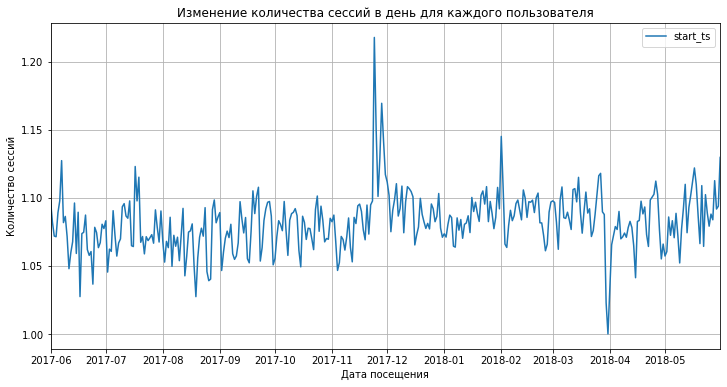

In [27]:
my_plot(sessions_per_user,'Изменение количества сессий в день для каждого пользователя',
        'Дата посещения', 'Количество сессий')
sessions_per_user.describe()

Каждый посетитель сайта совершает в среднем 1 сессию в день.
График изменения количества сессий в день для каждого пользователя похож на график изменения общего количества сессий в день: пик приходится на конец ноября, на период "черных пятниц" (максимальное значение 1.2). Также есть резкое падение в конце марта, возможно в это время велись технические работы на сайте.

#### ASL - cредняя продолжительность сессии

Для начала добавим в таблицу данные о продолжительности каждой сессии в секундах.

In [28]:
df_visits['session_duration_sec'] = (df_visits['end_ts']\
                                    - df_visits['start_ts']).dt.seconds
display(df_visits.head())

,device,end_ts,source_id,start_ts,user_id,session_year_number,session_month_number,session_week_number,session_date,session_duration_sec
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,12,51,2017-12-20,1080
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2,8,2018-02-19,1680
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,7,26,2017-07-01,0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,5,20,2018-05-20,1440
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017,12,52,2017-12-27,0


Сделаем срезы для каждого устройства.

In [29]:
df_visits_desktop = df_visits.query('device == "desktop"')
df_visits_touch = df_visits.query('device == "touch"')

Теперь с помощью функции построим сдвоенную гистограмму, чтобы оценить распределение величины в зависимости от устройства.

In [30]:
def my_hist(data1, data2, bins, range, title, x, y):
    data1.plot(kind='hist',
                                bins=bins,figsize=(12,6),range=range),
    data2.plot(kind='hist',
                                bins=bins,figsize=(12,6),range=range)
    plt.axvline(x=data1.median(),   
                linewidth=3,   
                color='red',  
                linestyle='--')
    plt.axvline(x=data1.quantile(.05),   
                linewidth=3, 
                color='y', 
                linestyle='--')
    plt.axvline(x=data1.quantile(.95),  
                linewidth=3, 
                color='y', 
                linestyle='--')
    plt.axvline(x=data2.median(),   
                linewidth=3,   
                color='red',  
                linestyle='--')
    plt.axvline(x=data2.quantile(.05),   
                linewidth=3, 
                color='y', 
                linestyle='--')
    plt.axvline(x=data2.quantile(.95),  
                linewidth=3, 
                color='y', 
                linestyle='--')
    plt.title(title, y=1.02)  
    plt.xlabel(x)  
    plt.ylabel(y)
    plt.minorticks_on()
    plt.grid(which='minor',alpha=0.4,color = 'k', linestyle = ':')
    plt.grid() 
    plt.show() 

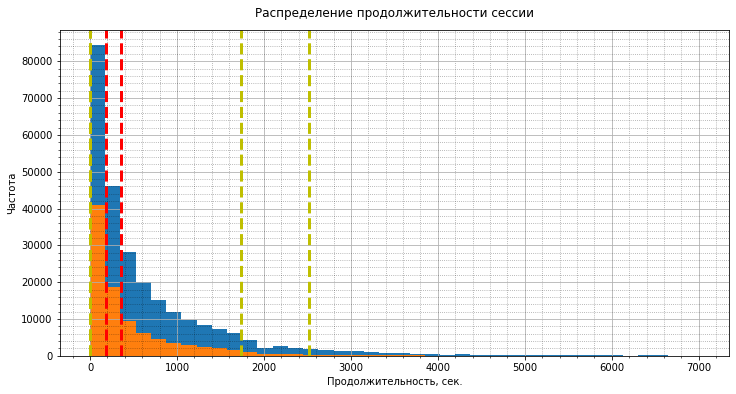

count    359400.000000
mean        643.506489
std        1016.334786
min           0.000000
25%         120.000000
50%         300.000000
75%         840.000000
max       84480.000000
Name: session_duration_sec, dtype: float64

In [31]:
my_hist(df_visits_desktop['session_duration_sec'],df_visits_touch['session_duration_sec'],
        40, (0,7000), 'Распределение продолжительности сессии', 'Продолжительность, сек.', 
        'Частота')
df_visits['session_duration_sec'].describe()

Мы видим, что распределение не нормальное, медиана сдвинута влево, есть длинный хвост в области больших значений, пик прижат к нулю. Среднее и мода такого распределения не покажут продолжительность типичной сесссии. Используем значение, которое делит распределение пополам - медиану.

In [32]:
print('Средняя продолжительность сессии для всех устройств:',
      int(df_visits['session_duration_sec'].median()),'секунд')
print('Средняя продолжительность сессии на ПК:',
      int(df_visits_desktop['session_duration_sec'].median()),'секунд')
print('Средняя продолжительность сессии на мобильном устройстве:',
      int(df_visits_touch['session_duration_sec'].median()),'секунд')

Средняя продолжительность сессии для всех устройств: 300 секунд
Средняя продолжительность сессии на ПК: 360 секунд
Средняя продолжительность сессии на мобильном устройстве: 180 секунд


Судя по медиане, средняя продолжительность сессии 300 секунд (или 5 минут). 
5 минут вполне достаточно для оформления заказа. 

Для ПК среднее значение чуть выше - 6 минут, а для мобильных устройств ниже - 3 минуты.
Возможно, на мобильных устройствах сайт работает быстрее, и пользователям хватет 3 минут. Также различие может быть вызвано размером заказа.

Частота для ПК выше, поскольку больше количество сессиий.

#### Retention Rate - коэффициент удержания

Для начала разделим пользоватлей на когорты.

Для этого нужно сгруппировать данные по столбцу user_id, для каждого клиента получим дату его первой сессии.
Добавим эти данные в общий датафрейм.

In [33]:
first_session_date_group = df_visits.groupby('user_id')['session_date'].min()

# изменим имя Series для объединения с общим датафреймом

first_session_date_group.name = 'first_session_date'

df_visits = df_visits.join(first_session_date_group, on='user_id')

Теперь выделим из столбцов first_session_date и session_date месяцы. Приведение к типу 'datetime64[M]' вернет для каждой записи первый день месяца.

In [34]:
df_visits['first_session_month'] = df_visits['first_session_date']\
                                    .astype('datetime64[M]')
df_visits['session_month'] = df_visits['session_date']\
                                .astype('datetime64[M]')

Когортой станет столбец first_session_month — месяц, в котором произошел первый визит. Сгруппируем данные по этому столбцу и оценим показатели каждой когорты.

In [35]:
cohort_grouped = df_visits.groupby('first_session_month').agg(
    {'user_id': 'nunique'})
print(cohort_grouped) 

                     user_id
first_session_month         
2017-06-01             13259
2017-07-01             13140
2017-08-01             10181
2017-09-01             16704
2017-10-01             25977
2017-11-01             27248
2017-12-01             25268
2018-01-01             22624
2018-02-01             22197
2018-03-01             20589
2018-04-01             15709
2018-05-01             15273


Теперь для каждой строки датафрейма рассчитаем lifetime пользователя в рамках когорты.

In [36]:
df_visits['cohort_lifetime'] = df_visits['session_month']\
                            - df_visits['first_session_month']

df_visits['cohort_lifetime'] = df_visits['cohort_lifetime']\
                            / np.timedelta64(1, 'M')
df_visits['cohort_lifetime'] = round(df_visits['cohort_lifetime'],0)

Сгруппируем данные по когорте и lifetime. Посчитаем для каждой когорты количество активных пользователей на определённую «неделю жизни»:

In [37]:
cohorts = df_visits.groupby(
    ['first_session_month','cohort_lifetime'])\
    .agg({'user_id':'nunique'}).reset_index() 
display(cohorts.head())

,first_session_month,cohort_lifetime,user_id
0,2017-06-01,0.0,13259
1,2017-06-01,1.0,1043
2,2017-06-01,2.0,713
3,2017-06-01,3.0,814
4,2017-06-01,4.0,909


Найдём исходное количество пользователей в когорте. Возьмём их число на нулевую неделю.

In [38]:
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][
    ['first_session_month', 'user_id']]
print(initial_users_count) 

   first_session_month  user_id
0           2017-06-01    13259
12          2017-07-01    13140
23          2017-08-01    10181
33          2017-09-01    16704
42          2017-10-01    25977
50          2017-11-01    27248
57          2017-12-01    25268
63          2018-01-01    22624
68          2018-02-01    22197
72          2018-03-01    20589
75          2018-04-01    15709
77          2018-05-01    15273


Переименуем столбец user_id в cohort_users и объединим данные по когортам с исходным количеством пользователей в когорте.

In [39]:
initial_users_count = initial_users_count\
                    .rename(columns={'user_id':'cohort_users'})

cohorts = cohorts.merge(initial_users_count,on='first_session_month') 

Рассчитаем Retention Rate. Разделим количество активных пользователей в каждую из недель на исходное число пользователей в когорте:

In [40]:
cohorts['retention'] = cohorts['user_id']/cohorts['cohort_users'] 

Retention Rate по нулевой когорте равен 100%, для удобства отображения на графике уберем эти данные из группировки. 

Зададим удобный формат даты.

In [41]:
cohorts_1 = cohorts.query('cohort_lifetime > 0')

In [42]:
cohorts_1['first_session_month'] = cohorts_1['first_session_month']\
                                    .dt.strftime('%Y-%m')

Построим сводную таблицу и создадим тепловую карту.

In [43]:
retention_pivot = cohorts_1.pivot_table(
    index='first_session_month',
    columns='cohort_lifetime',
    values='retention',
    aggfunc='sum',
)

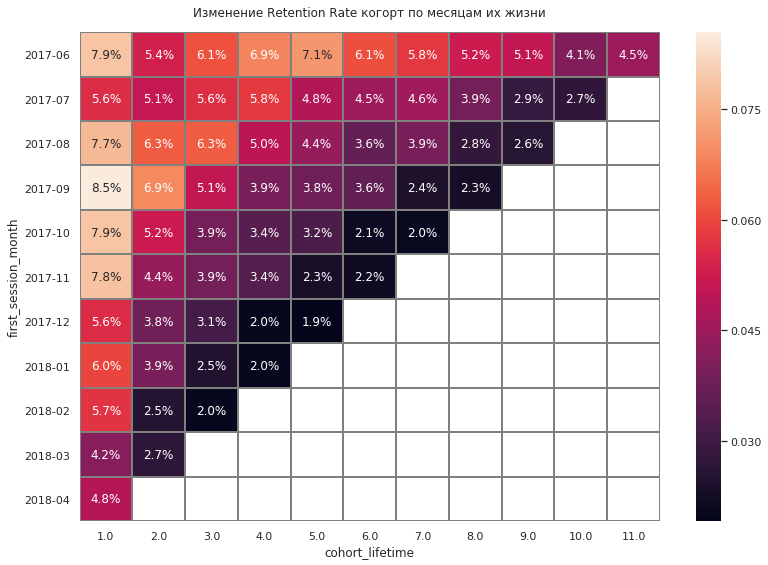

In [44]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Изменение Retention Rate когорт по месяцам их жизни', y=1.02)
sns.heatmap(retention_pivot, annot=True, fmt='.1%',\
            linewidths=1, linecolor='gray'); 

Расчитаем средний Retention Rate для второго месяца жизни.

In [45]:
cohorts_2 = cohorts.query('cohort_lifetime == 1')
print('Средний коэффициент удержания на второй месяц жизни когорт: {:.2%}'.format(cohorts_2['retention'].mean()))

Средний коэффициент удержания на второй месяц жизни когорт: 6.52%


На тепловой карте мы видим, что на второй месяц жизни когорты коэффициент удержания принимает самые высокие значения - в среднем 6,52%. При этом самый высокий RR у когорты сентября 2017 - 8,5%, а самый низкий - у когорты марта 2018. Средний коэффициент удержания на второй месяц жизни в 2017 году был выше, чем в 2018г. Пользователи стали реже возвращаться на сайт. Возможно, это связано с сезонностью, и во второй половине 2018г. они снова вернутся.

После второго месяца RR большинства когорт снижается с каждым следующим месяцем жизни, достигая 2-3% на месяц окончания исследования. Самая первая когорта (июнь 2017) показывает большие значения RR на протяжение всего цикла жизни, на месяц окончания исследования коэффициент составляет 4,5%.

Проведем когортный анализ для Retention Rate отдельно для каждого источника.

Средний коэффициент удержания на второй месяц жизни когорт для ПК: 6.38%


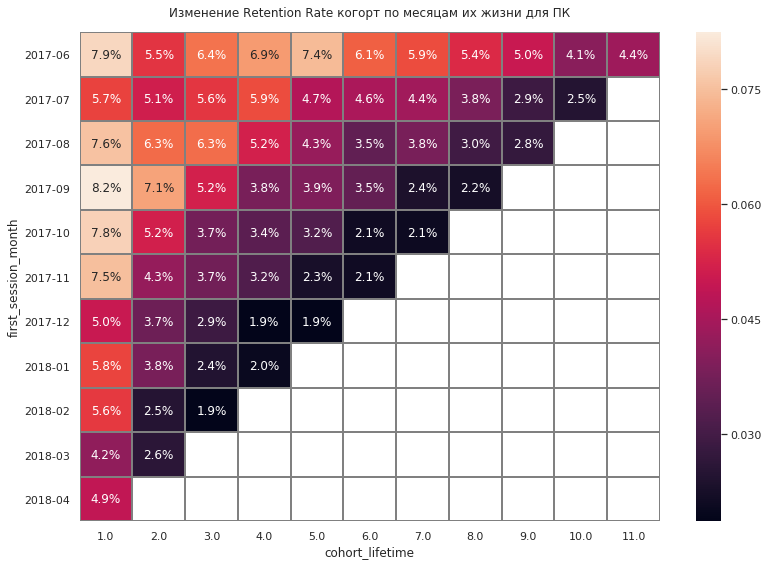

In [46]:
first_session_date_group_desktop = df_visits_desktop.groupby('user_id')['session_date'].min()
first_session_date_group_desktop.name = 'first_session_date'

df_visits_desktop = df_visits_desktop.join(first_session_date_group_desktop, on='user_id')
df_visits_desktop['first_session_month'] = df_visits_desktop['first_session_date']\
                                    .astype('datetime64[M]')
df_visits_desktop['session_month'] = df_visits_desktop['session_date']\
                                .astype('datetime64[M]')
cohort_grouped_desktop = df_visits_desktop.groupby('first_session_month').agg(
    {'user_id': 'nunique'})
df_visits_desktop['cohort_lifetime'] = df_visits_desktop['session_month']\
                            - df_visits_desktop['first_session_month']

df_visits_desktop['cohort_lifetime'] = df_visits_desktop['cohort_lifetime']\
                            / np.timedelta64(1, 'M')
df_visits_desktop['cohort_lifetime'] = round(df_visits_desktop['cohort_lifetime'],0)
cohorts_desktop = df_visits_desktop.groupby(
    ['first_session_month','cohort_lifetime'])\
    .agg({'user_id':'nunique'}).reset_index() 
initial_users_count_desktop = cohorts_desktop[cohorts_desktop['cohort_lifetime'] == 0][
    ['first_session_month', 'user_id']]
initial_users_count_desktop = initial_users_count_desktop\
                    .rename(columns={'user_id':'cohort_users'})

cohorts_desktop = cohorts_desktop.merge(initial_users_count_desktop,on='first_session_month') 
cohorts_desktop['retention'] = cohorts_desktop['user_id']/cohorts_desktop['cohort_users'] 
cohorts_desktop_1 = cohorts_desktop.query('cohort_lifetime > 0')
cohorts_desktop_1['first_session_month'] = cohorts_desktop_1['first_session_month']\
                                    .dt.strftime('%Y-%m')
retention_pivot_desktop = cohorts_desktop_1.pivot_table(
    index='first_session_month',
    columns='cohort_lifetime',
    values='retention',
    aggfunc='sum',
)
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Изменение Retention Rate когорт по месяцам их жизни для ПК', y=1.02)
sns.heatmap(retention_pivot_desktop, annot=True, fmt='.1%',\
            linewidths=1, linecolor='gray'); 
cohorts_desktop_2 = cohorts_desktop.query('cohort_lifetime == 1')
print('Средний коэффициент удержания на второй месяц жизни когорт для ПК: {:.2%}'.format(cohorts_desktop_2['retention'].mean()))

Средний коэффициент удержания на второй месяц жизни когорт для мобильных устройств: 5.17%


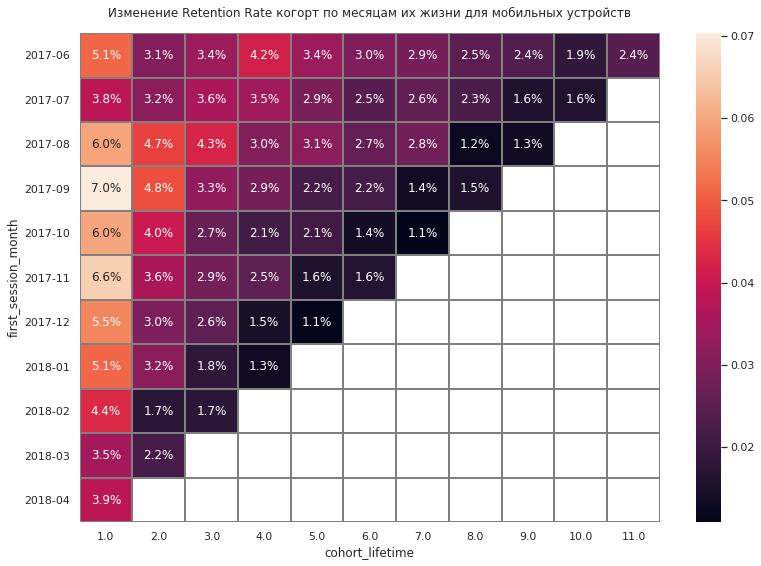

In [47]:
first_session_date_group_touch = df_visits_touch.groupby('user_id')['session_date'].min()
first_session_date_group_touch.name = 'first_session_date'

df_visits_touch = df_visits_touch.join(first_session_date_group_touch, on='user_id')
df_visits_touch['first_session_month'] = df_visits_touch['first_session_date']\
                                    .astype('datetime64[M]')
df_visits_touch['session_month'] = df_visits_touch['session_date']\
                                .astype('datetime64[M]')
cohort_grouped_touch = df_visits_touch.groupby('first_session_month').agg(
    {'user_id': 'nunique'})
df_visits_touch['cohort_lifetime'] = df_visits_touch['session_month']\
                            - df_visits_touch['first_session_month']

df_visits_touch['cohort_lifetime'] = df_visits_touch['cohort_lifetime']\
                            / np.timedelta64(1, 'M')
df_visits_touch['cohort_lifetime'] = round(df_visits_touch['cohort_lifetime'],0)
cohorts_touch = df_visits_touch.groupby(
    ['first_session_month','cohort_lifetime'])\
    .agg({'user_id':'nunique'}).reset_index() 
initial_users_count_touch = cohorts_touch[cohorts_touch['cohort_lifetime'] == 0][
    ['first_session_month', 'user_id']]
initial_users_count_touch = initial_users_count_touch\
                    .rename(columns={'user_id':'cohort_users'})

cohorts_touch = cohorts_touch.merge(initial_users_count_touch,on='first_session_month') 
cohorts_touch['retention'] = cohorts_touch['user_id']/cohorts_touch['cohort_users'] 
cohorts_touch_1 = cohorts_touch.query('cohort_lifetime > 0')
cohorts_touch_1['first_session_month'] = cohorts_touch_1['first_session_month']\
                                    .dt.strftime('%Y-%m')
retention_pivot_touch = cohorts_touch_1.pivot_table(
    index='first_session_month',
    columns='cohort_lifetime',
    values='retention',
    aggfunc='sum',
)
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Изменение Retention Rate когорт по месяцам их жизни для мобильных устройств', y=1.02)
sns.heatmap(retention_pivot_touch, annot=True, fmt='.1%',\
            linewidths=1, linecolor='gray'); 
cohorts_touch_2 = cohorts_touch.query('cohort_lifetime == 1')
print('Средний коэффициент удержания на второй месяц жизни когорт для мобильных устройств: {:.2%}'.format(cohorts_touch_2['retention'].mean()))

На тепловой карте для ПК мы видим, что на второй месяц жизни когорты коэффициент удержания принимает самые высокие значения - в среднем 6,38%. При этом самый высокий RR у когорты сентября 2017 - 8,2%, а самый низкий - у когорты марта 2018. Средний коэффициент удержания на второй месяц жизни в 2017 году был выше, чем в 2018г. Пользователи стали реже возвращаться на сайт.
Тепловая карта для ПК похожа на тепловую карту общего датасета.

Средний коэффициент удержания для мобильных устройств ниже - 5,17%. По-прежнему, самый высокий RR у когорты сентября 2017 - 7%, а самый низкий - у когорты марта 2018. 
Пользователи мобильных устройств реже возвращаются на сайт.

#### Вывод

Мы опрделили количество посетителей сайта Яндекс.Афиши за день, неделю и месяц - 907, 5716 и 23228 соответственно.

Фактор липкости показал, что пользователи редко возвращаются на сайт.

На графиках изменения количества пользователей по времени заметна сезонность, летом количество уникальных пользователей снижается, самый низкий месяц - август. Пик приходится на конец ноября, на период "черных пятниц".

На графике изменения дневного количества пользователей есть резкое падение в конце марта, возможно в это время велись технические работы на сайте.

Среднее количество сессий в день - 987, при этом количество уникальных пользователей в день - 907. Каждый пользователь совершает в среднем одну сессию в день. Если он при этом успевает совершить покупку, то это неплохо. 

Судя по медиане, средняя продолжительность сессии 300 секунд (или 5 минут). Для ПК среднее значение чуть выше - 6 минут, а для мобильных устройств ниже - 3 минуты. Возможно, на мобильных устройствах сайт работает быстрее, и пользователям хватает 3 минут. Также различие может быть вызвано размером заказа.

Коэффициент удержания достаточно низкий - самые высокие значения он принимает на втором месяце жизни когорты - в среднем 6,52%.  Средний коэффициент удержания на второй месяц жизни в 2017 году был выше, чем в 2018г. Пользователи стали реже возвращаться на сайт.
Самая первая когорта (июнь 2017) показыет большие значения RR на протяжение всего цикла жизни, на месяц окончания исследования коэффициент составляет 4,5%.

Это говорит о том, что в 2017 году сайт пользовался большей популярностью, пользователи когорт 2017г. в среднем чаще возвращаются.

Типичный пользователь заходит на сайт 1 раз в день на 60 секунд, и в большинстве случаев не возвращается.
Нужно подробнее изучить его поведение - узнать, на каком этапе он уходит и успевает ли сделать заказ.
Но уникальных пользователей не становится меньше - это хорошо, значит привлечение работает, а на удержание стоит обратить внимание. Различий между устройствами по длине сессии не обнаружено

Пользователей ПК-версии сайта в 2.5 раза больше, чем мобильной. Количество сессий ПК больше в 2.7 раз. Вероятно, мобильная версия менее удобна.

Средний коэффициент удержания для мобильных устройств ниже - 5,17% против 6,38% для ПК. Пользователи мобильных устройств реже возвращаются на сайт.

### Метрики электронной коммерции

#### Первая покупка

Узнаем, через какое время после первого посещения пользователи совершают первую покупку.

Сделаем группировку, где для каждого пользователя выберем дату первого заказа.

In [48]:
df_orders_1_group = df_orders_1.groupby('user_id')\
.agg({'buy_ts' : 'min'})
display(df_orders_1_group)

,buy_ts
user_id,
313578113262317,2018-01-03 21:51:00
1575281904278712,2017-06-03 10:13:00
2429014661409475,2017-10-11 18:33:00
2464366381792757,2018-01-28 15:54:00
2551852515556206,2017-11-24 10:14:00
...,...
18445147675727495770,2017-11-24 09:03:00
18445407535914413204,2017-09-22 23:55:00
18445601152732270159,2018-03-26 22:54:00


И такую же группировку для посещений сайта.

In [49]:
df_visits_group = df_visits.groupby('user_id')\
.agg({'first_session_date' : 'min'})
display(df_visits_group)

,first_session_date
user_id,
11863502262781,2018-03-01
49537067089222,2018-02-06
297729379853735,2017-06-07
313578113262317,2017-09-18
325320750514679,2017-09-30
...,...
18446403737806311543,2017-11-30
18446424184725333426,2017-12-06
18446556406699109058,2018-01-01


Соединим 2 группировки и найдем для каждого пользователя количество времени до первого заказа.

In [50]:
first_order = df_visits_group.join(df_orders_1_group, on='user_id')
display(first_order)

,first_session_date,buy_ts
user_id,,
11863502262781,2018-03-01,NaT
49537067089222,2018-02-06,NaT
297729379853735,2017-06-07,NaT
313578113262317,2017-09-18,2018-01-03 21:51:00
325320750514679,2017-09-30,NaT
...,...,...
18446403737806311543,2017-11-30,NaT
18446424184725333426,2017-12-06,NaT
18446556406699109058,2018-01-01,NaT


In [51]:
first_order['first_buy_date'] = pd.to_datetime(first_order['buy_ts'])
first_order['first_session_date'] =  pd.to_datetime(first_order['first_session_date'])

In [52]:
first_order['first_order_delta'] = first_order['first_buy_date'] - \
                            first_order['first_session_date']
display(first_order)

,first_session_date,buy_ts,first_buy_date,first_order_delta
user_id,,,,
11863502262781,2018-03-01,NaT,NaT,NaT
49537067089222,2018-02-06,NaT,NaT,NaT
297729379853735,2017-06-07,NaT,NaT,NaT
313578113262317,2017-09-18,2018-01-03 21:51:00,2018-01-03 21:51:00,107 days 21:51:00
325320750514679,2017-09-30,NaT,NaT,NaT
...,...,...,...,...
18446403737806311543,2017-11-30,NaT,NaT,NaT
18446424184725333426,2017-12-06,NaT,NaT,NaT
18446556406699109058,2018-01-01,NaT,NaT,NaT


Посмотрим на характеристики распределения среднего времени до первой покупки.

In [53]:
display(first_order['first_order_delta'].describe())
print('Среднее время до первой покупки:',first_order['first_order_delta'].median())

count                      36509
mean     17 days 13:07:30.206250
std      47 days 02:14:17.171794
min              0 days 00:00:00
25%              0 days 13:40:00
50%              0 days 19:22:00
75%              2 days 16:26:00
max            363 days 17:35:00
Name: first_order_delta, dtype: object

Среднее время до первой покупки: 0 days 19:22:00


Мы видим, что медиана распределения приходится на значение 19 часов 22 минуты, это значит, что как минимум 50% пользователей совершают первую покупку в день визита. При этом максимальное значение 363 дней. При таком распределении среднее арифметическое и мода нам не подходят.

В среднем посетители сайта делают свой первый заказ в день первого посещения, точнее через 19 часов. Это хороший показатель, значит покупателей устраивает сервис и цена. Задержка может быть связана с необходимостью найти компанию для посещения мероприятия.

Посмотрим, есть ли отличия во времени до первой покупки между устройствами.

In [54]:
df_visits_group_desktop = df_visits_desktop.groupby('user_id')\
.agg({'first_session_date' : 'min'})

first_order_desktop = df_visits_group_desktop.join(df_orders_1_group, on='user_id')
first_order_desktop['first_buy_date'] = pd.to_datetime(first_order_desktop['buy_ts'])
first_order_desktop['first_session_date'] = pd.to_datetime(first_order_desktop['first_session_date'])
first_order_desktop['first_order_delta'] = first_order_desktop['first_buy_date'] - \
                            first_order_desktop['first_session_date']
first_order_desktop['first_order_delta'].describe()

count                      30589
mean     15 days 12:03:40.738173
std      47 days 05:52:59.161659
min          -319 days +10:49:00
25%              0 days 13:19:00
50%              0 days 18:42:00
75%              1 days 18:53:00
max            363 days 17:35:00
Name: first_order_delta, dtype: object

In [55]:
df_visits_group_touch = df_visits_touch.groupby('user_id')\
.agg({'first_session_date' : 'min'})

first_order_touch = df_visits_group_touch.join(df_orders_1_group, on='user_id')
first_order_touch['first_buy_date'] = pd.to_datetime(first_order_touch['buy_ts'])
first_order_touch['first_session_date'] = pd.to_datetime(first_order_touch['first_session_date'])
first_order_touch['first_order_delta'] = first_order_touch['first_buy_date'] - \
                            first_order_touch['first_session_date']
first_order_touch['first_order_delta'].describe()

count                       8911
mean     10 days 01:33:55.185725
std      61 days 22:52:13.195444
min          -354 days +08:42:00
25%              0 days 12:04:00
50%              0 days 19:48:00
75%              4 days 18:13:00
max            363 days 11:34:00
Name: first_order_delta, dtype: object

Мы видим, что медиана распределения для каждого из устройств приходится на значение 0 дней, точнее 18 часов 42 минуты для ПК и 19 часов 48 минут для мобильных устройств. Разницу в 1 час можно считать несущественной.

#### Количество покупок на одного покупателя 

Для того, чтобы расчитать среднее количество покупок на одного покупателя за определённый период, выберем период в 6 месяцев.

In [56]:
display(df_orders_1['buy_ts'].min())

Timestamp('2017-06-01 00:10:00')

In [57]:
df_orders_2 = df_orders_1[df_orders_1['buy_ts'] < '2017-12-01']

Сделаем группировку по пользователям и посчитаем количество покупок.

In [58]:
df_orders_cnt = df_orders_2.groupby('user_id').agg({'buy_ts':'count'})

In [59]:
display(df_orders_cnt)

,buy_ts
user_id,
1575281904278712,2
2429014661409475,1
2551852515556206,2
3605148382144603,3
5081614443770358,1
...,...
18438888612344691875,1
18439162270906870763,1
18445147675727495770,1


In [60]:
print('В среднем каждый покупатель совершает:',\
 round(df_orders_cnt['buy_ts'].mean(),1),'заказа')

В среднем каждый покупатель совершает: 1.3 заказа


Сделаем группировки по устройствам и посмотрим, есть ли зависимость от типа устройства.

In [61]:
users_desktop = df_visits_desktop.groupby('user_id').agg({'device':'first'})
desktop_orders_cnt = users_desktop.merge(df_orders_cnt, on='user_id',how='inner')
print('В среднем каждый покупатель с ПК совершает:',\
 round(desktop_orders_cnt['buy_ts'].mean(),1),'заказа')

В среднем каждый покупатель с ПК совершает: 1.3 заказа


In [62]:
users_touch = df_visits_touch.groupby('user_id').agg({'device':'first'})
touch_orders_cnt = users_touch.merge(df_orders_cnt, on='user_id',how='inner')
print('В среднем каждый покупатель с мобильного устройства совершает:',\
 round(touch_orders_cnt['buy_ts'].mean(),1),'заказа')

В среднем каждый покупатель с мобильного устройства совершает: 1.4 заказа


Покупатели совершают в среднем 1 покупку, то есть не возвращаются повторно в течение полугода.

Нужно узнать статус покупателей для того, чтобы дать оценку этому количеству покупок. Если покупатель - частное лицо, то 1 покупка - это мало.
Для организатора событий и инфопартнера - 1 покупка может давать доступ на несколько месяцев, тогда это ожидаемый результат.

Устройство не влияет на этот показатель.

#### AOV - средний чек

Для расчета среднего чека нужно разделить выручку на количество покупок.

Для отображения изменения метрики во времени сделаем группировку по месяцу совершения покупки. 

In [63]:
df_orders_1['buy_month'] = df_orders_1['buy_ts'].dt.month

In [64]:
order_value_group = df_orders_1.groupby('buy_month')\
                    .agg({'revenue':'sum','buy_ts':'count'})

In [65]:
display(order_value_group)

,revenue,buy_ts
buy_month,,
1,19417.13,4721
2,25560.54,5280
3,28834.59,5325
4,16858.06,3265
5,20735.98,4344
6,9560.91,2354
7,12539.47,2362
8,8758.78,1803
9,18345.51,3383


In [66]:
order_value_group['order_value']  = \
order_value_group['revenue'] / order_value_group['buy_ts']

In [67]:
print('Средний чек составляет:', 
      round(order_value_group['order_value'].mean(),2),'у.е.')

Средний чек составляет: 4.96 у.е.


<div class="alert alert-success">
    <b>Комментарий ревьюера: </b> Все верно. </div>

In [68]:
display(order_value_group)

,revenue,buy_ts,order_value
buy_month,,,
1,19417.13,4721,4.112927
2,25560.54,5280,4.841011
3,28834.59,5325,5.414946
4,16858.06,3265,5.163265
5,20735.98,4344,4.773476
6,9560.91,2354,4.061559
7,12539.47,2362,5.308836
8,8758.78,1803,4.857892
9,18345.51,3383,5.422852


Сохраним в новую переменную данные, которые нужны для построения графика и с помощью функции построим график зависимости среднего чека от месяца покупки.

In [69]:
order_value_plt = order_value_group.pivot_table(index='buy_month',\
                                                values='order_value')

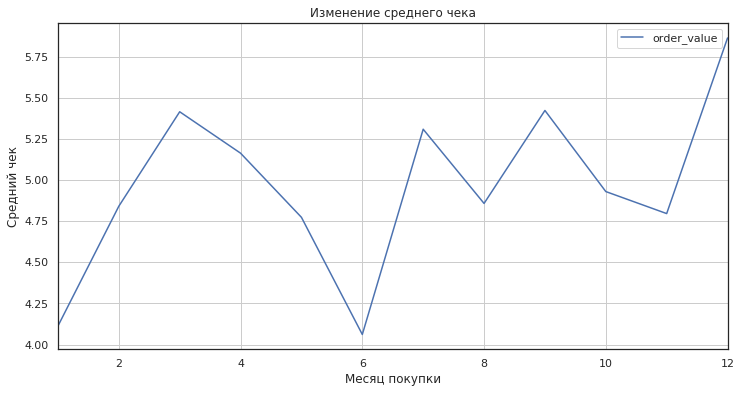

In [70]:
my_plot(order_value_plt,'Изменение среднего чека',
        'Месяц покупки', 'Средний чек')

Средний чек за весь год составляет 4,96у.е. Для оценки этой метрики нужно иметь представление о ценах предоставляемых товаров и услуг.

По графику изменения среднего чека по времени мы видим, что самые высокие значения метрика принимает в декабре, за ним идут март, сентябрь, июль и апрель. Самые низкие месяцы - январь и июнь. В остальное время средний чек держится в районе 4,8у.е.

Эти данные можно использовать для планирования продаж.

Посмотрим на изменение среднего чека для разных устройств.

Средний чек для ПК составляет: 5.15 у.е.


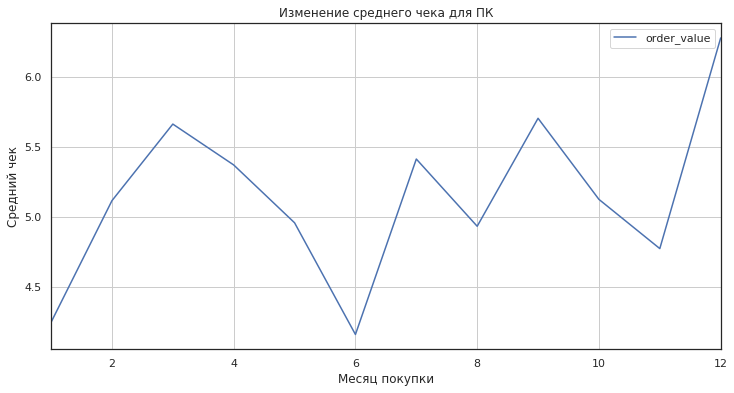

In [71]:
desktop_orders = users_desktop.merge(df_orders_1, on='user_id',how='inner')
desktop_orders['buy_month'] = desktop_orders['buy_ts'].dt.month
desktop_order_value_group = desktop_orders.groupby('buy_month')\
                    .agg({'revenue':'sum','buy_ts':'count'})
desktop_order_value_group['order_value']  = \
            desktop_order_value_group['revenue'] / desktop_order_value_group['buy_ts']

print('Средний чек для ПК составляет:', 
      round(desktop_order_value_group['order_value'].mean(),2),'у.е.')

desktop_order_value_plt = (desktop_order_value_group.pivot_table(index='buy_month', values='order_value'))

my_plot(desktop_order_value_plt,'Изменение среднего чека для ПК','Месяц покупки', 'Средний чек')

Средний чек для мобильных устройств составляет: 4.81 у.е.


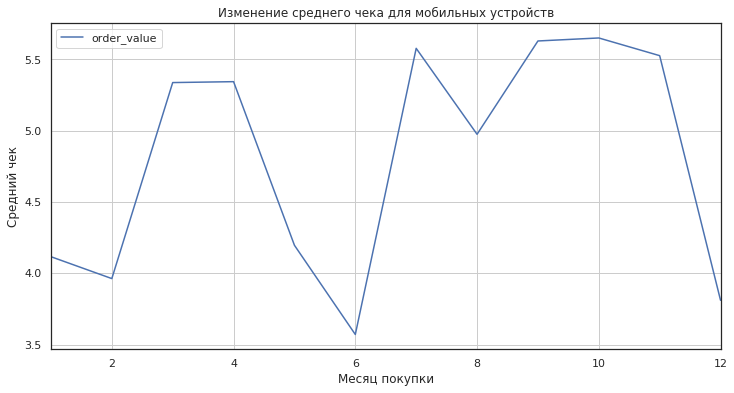

In [72]:
touch_orders = users_touch.merge(df_orders_1, on='user_id',how='inner')
touch_orders['buy_month'] = touch_orders['buy_ts'].dt.month
touch_order_value_group = touch_orders.groupby('buy_month')\
                    .agg({'revenue':'sum','buy_ts':'count'})
touch_order_value_group['order_value']  = \
            touch_order_value_group['revenue'] / touch_order_value_group['buy_ts']

print('Средний чек для мобильных устройств составляет:', 
      round(touch_order_value_group['order_value'].mean(),2),'у.е.')

touch_order_value_plt = (touch_order_value_group.pivot_table(index='buy_month', values='order_value'))

my_plot(touch_order_value_plt,'Изменение среднего чека для мобильных устройств','Месяц покупки', 'Средний чек')

Средний чек для ПК выше - 5,15у.е вместо 4,81у.е. для мобильных устройств.

Графики изменения среднего чека по времени похожи, различия есть в феврале (чек ПК растет, а чек мобильных устройств падает) и в ноябре (чек ПК падает, а чек мобильных устройств растет). Возможно в эти месяцы проводились технические работы на сайте, осложняя доступ для одного из типов устройств.

#### LTV - совокупная ценность клиента

LTV - это итоговая сумма денег, которую средний клиент приносит компании со всех своих покупок за определенный период.

In [73]:
total_revenue = df_orders_1['revenue'].sum()
total_buyers = df_orders_1['user_id'].nunique()
print('Общая сумма дохода за год:', total_revenue,'у.е.')
print('Количество покупателей за год:', total_buyers)

Общая сумма дохода за год: 252057.2 у.е.
Количество покупателей за год: 36509


In [74]:
print('LTV за год:', (total_revenue / total_buyers).round(2),'у.е.')

LTV за год: 6.9 у.е.


Для анализа изменения этой метрики по когортам, мы будем использовать когорты, прожившие не менее 6 месяцев. LTV - накопительная величина, поэтому нужно чтобы срок жизни когорт был одинаковым.

Для начала разделим пользоватлей на когорты. 
Для этого нужно сгруппировать данные по столбцу user_id, для каждого клиента получим дату его первой покупки. Добавим эти данные в общий датафрейм.

In [75]:
first_buy_date_group = df_orders_1.groupby('user_id')['buy_ts'].min()
first_buy_date_group.name = 'first_buy_date'

df_orders_1 = (df_orders_1.join(first_buy_date_group, on='user_id'))
display(df_orders_1)

,buy_ts,revenue,user_id,buy_month,first_buy_date
0,2017-06-01 00:10:00,17.00,10329302124590727494,6,2017-06-01 00:10:00
1,2017-06-01 00:25:00,0.55,11627257723692907447,6,2017-06-01 00:25:00
2,2017-06-01 00:27:00,0.37,17903680561304213844,6,2017-06-01 00:27:00
3,2017-06-01 00:29:00,0.55,16109239769442553005,6,2017-06-01 00:29:00
4,2017-06-01 07:58:00,0.37,14200605875248379450,6,2017-06-01 07:58:00
...,...,...,...,...,...
50410,2018-05-31 23:50:00,4.64,12296626599487328624,5,2018-05-31 23:50:00
50411,2018-05-31 23:50:00,5.80,11369640365507475976,5,2018-05-31 23:50:00
50412,2018-05-31 23:54:00,0.30,1786462140797698849,5,2018-05-31 23:54:00
50413,2018-05-31 23:56:00,3.67,3993697860786194247,5,2018-05-31 23:56:00


Теперь выделим из столбцов first_buy_date и buy_ts месяцы. Приведение к типу 'datetime64[M]' вернет для каждой записи первый день месяца.

In [76]:
df_orders_1['first_buy_month'] = df_orders_1['first_buy_date']\
                                .astype('datetime64[M]')
df_orders_1['buy_month'] = df_orders_1['buy_ts']\
                                .astype('datetime64[M]')

Теперь рассчитаем lifetime пользователя в рамках когорты.

In [77]:
df_orders_1['cohort_lifetime'] = (
    df_orders_1['buy_month'] - df_orders_1['first_buy_month'])

df_orders_1['cohort_lifetime'] = df_orders_1['cohort_lifetime']\
                            / np.timedelta64(1, 'M')
df_orders_1['cohort_lifetime']  = round(df_orders_1['cohort_lifetime'] ,0)

Сгруппируем таблицу заказов по месяцу первой покупки и месяцу каждого заказа и сложим выручку.

In [78]:
cohorts_buy = (df_orders_1.groupby(['first_buy_month', 'buy_month'])\
               .agg({'revenue': 'sum'}).reset_index())

Добавим в таблицу cohorts данные о том, сколько людей первый раз совершили покупку в каждом месяце.

In [79]:
cohort_sizes = df_orders_1.groupby('first_buy_month')\
                .agg({'user_id': 'nunique'}).reset_index()

cohort_sizes.columns = ['first_buy_month', 'n_buyers']
print(cohort_sizes.head()) 

  first_buy_month  n_buyers
0      2017-06-01      2022
1      2017-07-01      1922
2      2017-08-01      1369
3      2017-09-01      2579
4      2017-10-01      4340


In [80]:
report = pd.merge(cohort_sizes, cohorts_buy, on='first_buy_month')
print(report.head()) 

  first_buy_month  n_buyers  buy_month  revenue
0      2017-06-01      2022 2017-06-01  9557.49
1      2017-06-01      2022 2017-07-01   981.82
2      2017-06-01      2022 2017-08-01   885.34
3      2017-06-01      2022 2017-09-01  1931.30
4      2017-06-01      2022 2017-10-01  2068.58


LTV считают не из выручки, а из валовой прибыли. Валовая прибыль - это произведение выручки и маржинальности.
Но в нашем случае маржинальность равна 100% (или 1), значит дополнительные операции не требуются.

LTV — относительный показатель. Значит его удобнее смотреть по «возрастным» когортам, где в столбцах — не месяц заказа, а возраст когорты. Добавим данные о возврасте в датафрейм.

In [81]:
report['age'] = (report['buy_month'] - report['first_buy_month'])\
                / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')
report['ltv'] = report['revenue'] / report['n_buyers']

Делаем срез только по когортам, прожившим 6 месяцев.

In [82]:
report_6m = report.query('(first_buy_month < "2017-12-01") & (age < 7)')

In [83]:
report_6m['first_buy_month'] = report_6m['first_buy_month']\
                                    .dt.strftime('%Y-%m')

Сделаем когортный отчёт и построим график.

In [84]:
output = report_6m.pivot_table(index='first_buy_month', \
                columns='age', values='ltv', aggfunc='sum').cumsum(axis=1)
display(output.round(2).fillna(''))

age,0,1,2,3,4,5,6
first_buy_month,,,,,,,
2017-06,4.73,5.21,5.65,6.61,7.63,8.36,9.31
2017-07,6.01,6.35,6.97,7.33,7.51,7.66,7.79
2017-08,5.28,5.75,6.21,6.60,7.10,7.38,7.59
2017-09,5.65,6.77,7.29,11.27,11.67,12.31,13.02
2017-10,5.00,5.54,5.73,5.89,6.04,6.16,6.24
2017-11,5.16,5.56,5.76,6.08,6.23,6.28,6.40


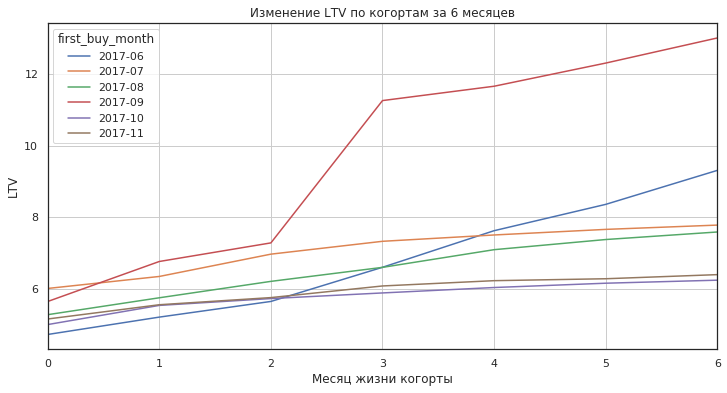

In [85]:
my_plot(output.T,'Изменение LTV по когортам за 6 месяцев',
        'Месяц жизни когорты', 'LTV')

На графике видно, что лидером по ltv за 6 месяцев стала сентябрьская когорта - уровень ltv на 6м месяце жизни значительно больше, чем у других когорт - 13у.е. Явно заметен скачок на 3 месяце жизни этой когорты - в декабре 2017г. Стоит обратить внимание, на источники привлечения покупателей на сайт в сентябре. Возможно в сентябре на сайт прибыла аудитория, для которой в декабре были очень выгодные предложения.

Также стоит отметить июньскую когорту, она стартовала с наименьшим значением ltv, а по итогу 6 месяца жизни вышла на второе место.

Построим тепловую карту для всех когорт.

In [86]:
report['first_buy_month'] = report['first_buy_month'].dt.strftime('%Y-%m')

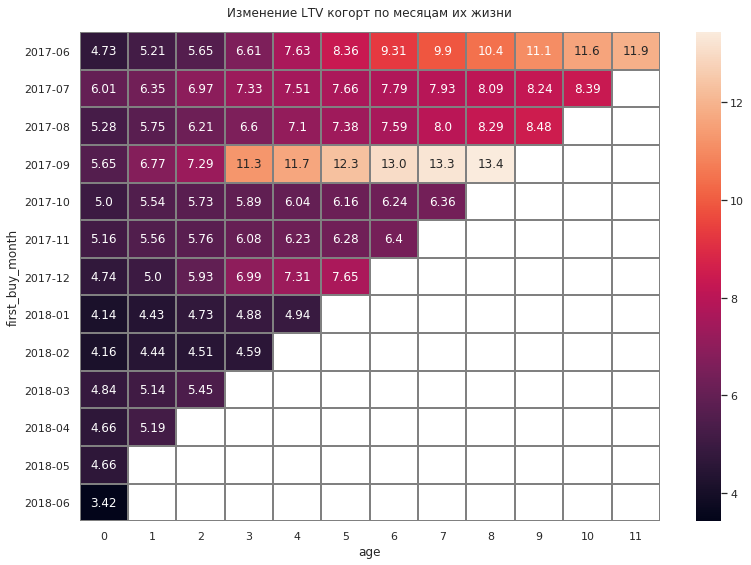

In [87]:
output_ = report.pivot_table(index='first_buy_month', \
                columns='age', values='ltv', aggfunc='sum').cumsum(axis=1)

sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Изменение LTV когорт по месяцам их жизни', y=1.02)
sns.heatmap(output_.round(2), annot=True, fmt='.3',\
            linewidths=1, linecolor='gray'); 

На тепловой карте видно, что сентябрьская когорта лидирует на протяжении всех месяцев. Июньская вышла на второе место только на пятом месяце жизни. Когорты 2018 года показывают более скромные результаты. Возможно, это связано с сезонностью, но мы рассматриваем только 1 год жизни.

Посмотрим, как меняется LTV  в зависимости от устройства.

Средний LTV для разных устройств составляет: device
desktop    6.10
touch      5.07
dtype: float64 у.е.


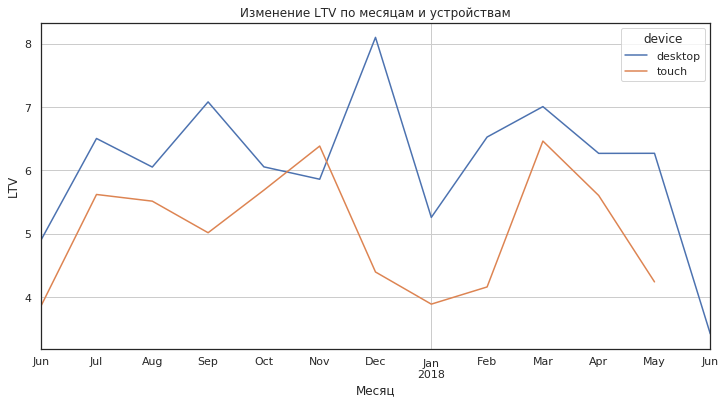

In [88]:
first_device = df_visits.sort_values('start_ts').groupby('user_id').first() 
first_device = first_device[['device']]

df_orders_device = pd.merge(df_orders_1, first_device, left_on='user_id',right_index=True) 
ltv_group = df_orders_device.groupby(['buy_month','device']).agg({'user_id':'nunique','revenue':'sum'}).reset_index() 
ltv_group.rename(columns={'user_id':'n_buyers'}, inplace=True) 
ltv_group['ltv'] = ltv_group['revenue'] / ltv_group['n_buyers'] 
ltv_pivot_device = ltv_group.pivot_table(index=['buy_month'], columns='device', values='ltv',aggfunc='mean') 

print('Средний LTV для разных устройств составляет:', 
      round(ltv_pivot_device.mean(),2),'у.е.');

my_plot(ltv_pivot_device,'Изменение LTV по месяцам и устройствам', 'Месяц', 'LTV')

Видим, что средний LTV для ПК выше, чем для мобильных устройств - 6,1у.е. против 5,07у.е.
По сезонности есть изменения в ноябре - LTV мобильных устройств обгоняет ПК, в декабре - наоборот, ПК показывает максимальные годовые значения, а мобильные устройства - ниже среднего.
В июне 2018 был только 1 покупатель - пользователь ПК, поэтому кривая для мобильных устройств обрывается.

#### Вывод

В среднем посетители сайта делают свой первый заказ в день первого посещения, через 19 часов. Это хороший показатель, значит покупателей устраивает сервис и цена. Задержка может быть связана с необходимостью найти компанию для посещения мероприятия.

Покупатели совершают в среднем 1 покупку (точнее 1,3), то есть не возвращаются повторно в течение полугода.
Нужно узнать статус покупателей для того, чтобы дать оценку этому количеству покупок. Если покупатель - частное лицо, то 1 покупка - это мало.
Для организатора событий и инфопартнера - 1 покупка может давать доступ на несколько месяцев, тогда это ожидаемый результат.

Тип устройства не влияет на время до первой покупки и на количество покупок.

Средний чек за весь год составляет 4,96у.е. Для оценки этой метрики нужно иметь представление о ценах предоставляемых товаров и услуг.
По графику изменения среднего чека во времени мы видим, что самые высокие значения метрика принимает в декабре.

Средний чек для ПК выше - 5,15у.е вместо 4,81у.е. для мобильных устройств.

LTV за весь год составляет 6.9у.е.
На графике видно, что лидером по ltv за 6 месяцев стала сентябрьская когорта - уровень ltv на 6м месяце жизни - 13у.е. Явно заметен скачок в декабре 2017г. Стоит обратить внимание, на источники привлечения покупателей на сайт в сентябре. Возможно в сентябре на сайт прибыла аудитория, для которой в декабре были очень выгодные предложения.

Средний LTV для ПК выше, чем для мобильных устройств - 6,1у.е. против 5,07у.е.
По сезонности есть различия: в ноябре - LTV мобильных устройств на пике, в декабре - наоборот, напике ПК, а мобильные устройства - ниже среднего.

### Маркетинговые метрики

#### Общая сумма расходов

In [89]:
total_costs = df_costs['costs'].sum()
print('Общая сумма расходов на маркетинг за год:', total_costs,'у.е.')

Общая сумма расходов на маркетинг за год: 329131.62 у.е.


In [90]:
df_costs['date_month'] = df_costs['date'].dt.strftime('%Y-%m')

In [91]:
source_pivot = df_costs.pivot_table(index='source_id',columns='date_month',values='costs',aggfunc='sum')
display(source_pivot)

date_month,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05
source_id,,,,,,,,,,,,
1,1125.61,1072.88,951.81,1502.01,2315.75,2445.16,2341.20,2186.18,2204.48,1893.09,1327.49,1467.61
2,2427.38,2333.11,1811.05,2985.66,4845.00,5247.68,4897.80,4157.74,4474.34,3943.14,2993.70,2689.44
3,7731.65,7674.37,6143.54,9963.55,15737.24,17025.34,16219.52,14808.78,14228.56,13080.85,9296.81,9411.42
4,3514.80,3529.73,3217.36,5192.26,6420.84,5388.82,7680.47,5832.79,5711.96,5961.87,4408.49,4214.21
5,2616.12,2998.14,2185.28,3849.14,5767.40,6325.34,5872.52,5371.52,5071.31,4529.62,3501.15,3669.56
9,285.22,302.54,248.93,415.62,609.41,683.18,657.98,547.16,551.50,480.29,373.49,362.17
10,314.22,329.82,232.57,460.67,627.24,792.36,645.86,614.35,480.88,526.41,388.25,409.86


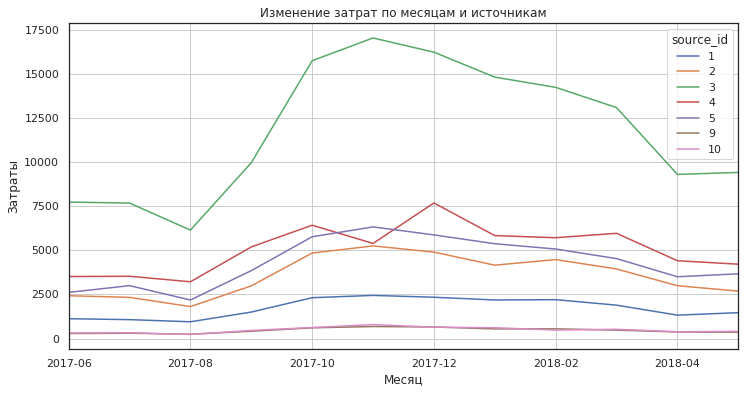

In [92]:
my_plot(source_pivot.T,'Изменение затрат по месяцам и источникам',
        'Месяц', 'Затраты')

График показывает, что наиболее затратным для компании является источник №3, его затраты значительно превышают затраты других источников. Также мы видим начало увеличения затрат в сенятбре 2017г. 
В ноябре затраты достигают пиковых значений (по всем источникам, кроме №4). 

Общая сумма расходов на маркетинг за год: 329'131.62 у.е.


#### CAC - стоимость привлечения клиента

In [93]:
print('Количество уникальных покупателей за год:', df_orders['user_id'].nunique())

Количество уникальных покупателей за год: 36523


Разделив общие расходы на маркетинг за год на количество уникальных покупателей, получим стоимость привлечения одного клиента.

In [94]:
total_cac = total_costs / df_orders['user_id'].nunique()
print('Стоимость привлечения одного клиента:', total_cac.round(2), 'у.е.')

Стоимость привлечения одного клиента: 9.01 у.е.


Для расчета среднего CAC на одного покупателя для каждого источника трафика, нужно определить источник привлечения клиента.
Будем считать, что источник, с которого произошло первое посещение сайта, является основным.

In [95]:
first_source = df_visits.sort_values('start_ts').groupby('user_id').first() 
first_source = first_source[['source_id']]
df_orders_source = pd.merge(df_orders_1, first_source, left_on='user_id',right_index=True)

In [96]:
df_orders_source['first_buy_date'] = df_orders_source['first_buy_date'].dt.strftime('%Y-%m-%d')
df_costs['date'] = df_costs['date'].dt.strftime('%Y-%m-%d')

Сгруппируем данные о покупках по источнику и дате первой покупки.

In [97]:
df_orders_source_group = df_orders_source.groupby(['source_id','first_buy_date'])\
.agg({'user_id':'nunique'}).reset_index()
df_orders_source_group.rename(columns={'user_id':'n_buyers'}, inplace=True)

Добавим данные о затратах и посчитаем CAC для каждого источника.

In [98]:
df_costs['costs_month'] = df_costs['date'].astype('datetime64[M]')
orders_costs = pd.merge(df_orders_source_group,df_costs,left_on=['source_id', 'first_buy_date'],right_on=['source_id','date'])
orders_costs['cac'] = orders_costs['costs'] / orders_costs['n_buyers']

In [99]:
round(orders_costs.groupby('source_id')['cac'].mean(),2)

source_id
1      9.51
2     16.33
3     15.59
4      7.27
5      8.34
9      6.84
10     6.56
Name: cac, dtype: float64

Посмотрим, как менялся CAC в течение года.

In [100]:
orders_costs_pivot = orders_costs.pivot_table(index=['costs_month'], columns='source_id', values='cac',aggfunc='mean')
display(orders_costs_pivot)

source_id,1,2,3,4,5,9,10
costs_month,,,,,,,
2017-06-01,11.681283,13.122874,16.716919,10.792094,9.209676,5.253654,4.590158
2017-07-01,9.491485,18.000253,18.636711,8.054482,7.938157,5.582433,6.151880
2017-08-01,12.118898,18.976799,19.795068,11.554926,6.879620,4.900254,5.813398
2017-09-01,8.155731,17.812067,13.084043,9.533800,6.864844,6.049126,8.306581
2017-10-01,8.202083,14.193003,14.613088,6.233562,6.305969,5.923235,6.362921
2017-11-01,8.908503,17.417977,16.123126,5.013132,9.368019,9.400503,10.827665
2017-12-01,8.580205,13.882445,12.960291,5.656507,8.399174,7.899420,7.803197
2018-01-01,11.719181,15.850151,15.134989,5.901092,9.371755,9.792713,9.851557
2018-02-01,10.752216,18.206325,13.894612,5.428068,7.725369,8.181382,4.489624


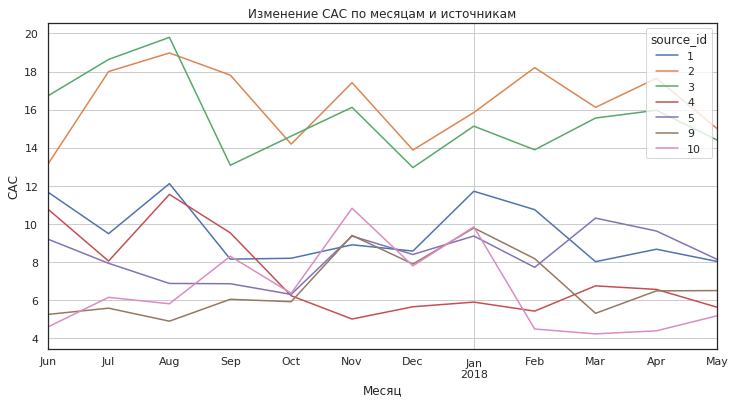

In [101]:
my_plot(orders_costs_pivot, 'Изменение CAC по месяцам и источникам', 'Месяц', 'CAC')

На графике видно, что привлечение клиентов по источникам 2 и 3 обходится дороже. Меньше всего компания тратит на привлечение по источнику 9.
Наблюдается 3 сезонных пика - август, ноябрь и январь.

Стоимость привлечения одного клиента: 9.01 у.е.

#### ROMI - окупаемость маркетинговых инвестиций

Соберем все необходимые данные в одну таблицу.

In [102]:
df_orders_device_source =  pd.merge(df_orders_device, first_source, left_on='user_id',right_index=True)
orders_device_source_group = df_orders_device_source.groupby(['first_buy_month','buy_month','cohort_lifetime','device','source_id']).agg({'user_id':'nunique','revenue':'sum'}).reset_index()
orders_device_source_group.rename(columns={'user_id':'n_buyers'}, inplace=True)
source_costs_ = df_costs.groupby(['source_id','costs_month'])['costs'].sum().reset_index()

marketing = pd.merge(orders_device_source_group, source_costs_,\
                    left_on=['source_id', 'buy_month'],right_on=['source_id','costs_month'])

Расчитаем ltv, cac и romi.

In [103]:
marketing['ltv'] = marketing['revenue'] / marketing['n_buyers']
marketing['cac'] = marketing['costs'] / marketing['n_buyers']
marketing['romi'] = marketing['ltv'] / marketing['cac']

Сделаем группировки по устройству и по источнику.

In [104]:
romi_pivot_device = marketing.pivot_table(index=['costs_month'], columns='device', values='romi',aggfunc='mean')
romi_pivot_source = marketing.pivot_table(index=['costs_month'], columns='source_id', values='romi',aggfunc='mean')

Уберем первый месяц жизни когорт.

In [105]:
romi_1 = marketing.query('cohort_lifetime > 0')
romi_1['first_buy_month'] = romi_1['first_buy_month']\
                                    .dt.strftime('%Y-%m')

In [106]:
romi_pivot_cohorts = romi_1.pivot_table(
    index='first_buy_month',
    columns='cohort_lifetime',
    values='romi',
    aggfunc='sum',
)
romi_pivot_cohorts.cumsum(axis=1).round(2).fillna('')

cohort_lifetime,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0
first_buy_month,,,,,,,,,,,
2017-06,0.62,1.37,2.24,2.83,3.21,3.69,4.07,4.47,4.83,5.27,5.54
2017-07,0.41,1.12,1.33,1.45,1.54,1.62,1.7,1.84,2,2.15,
2017-08,0.25,0.46,0.59,0.73,0.83,0.91,1.16,1.4,1.53,,
2017-09,0.78,1.1,3.01,3.29,3.63,4.11,4.45,4.83,,,
2017-10,0.55,0.78,0.97,1.17,1.4,1.55,1.75,,,,
2017-11,0.32,0.6,1.03,1.22,1.32,1.47,,,,,
2017-12,0.33,1.25,2.48,2.91,3.49,,,,,,
2018-01,0.21,0.49,0.72,0.79,,,,,,,
2018-02,0.31,0.4,0.51,,,,,,,,


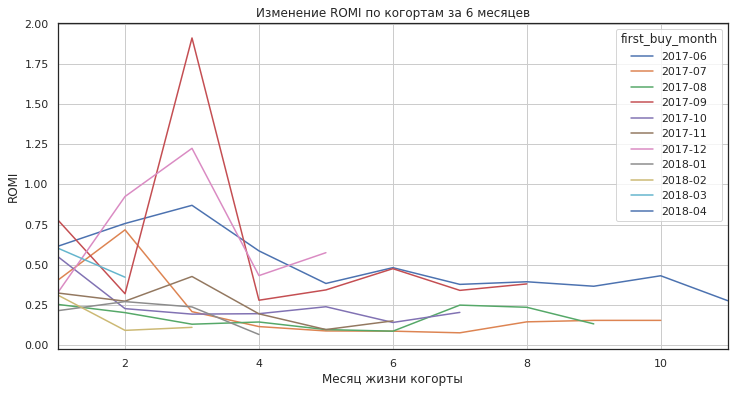

In [107]:
my_plot(romi_pivot_cohorts.T,'Изменение ROMI по когортам за 6 месяцев',
        'Месяц жизни когорты', 'ROMI')

Самые большие значения принимает ROMI сентябрьской когорты. На втором месте - декабрьская когорта. 

Посмотрим, на каком месяце жизни средний ROMI по когортам достигает единицы.

In [108]:
romi_pivot_cohorts.cumsum(axis=1).mean(axis=0)

cohort_lifetime
1.0     0.422836
2.0     0.859102
3.0     1.430927
4.0     1.797539
5.0     2.202104
6.0     2.225515
7.0     2.626762
8.0     3.135032
9.0     2.788073
10.0    3.709327
11.0    5.542700
dtype: float64

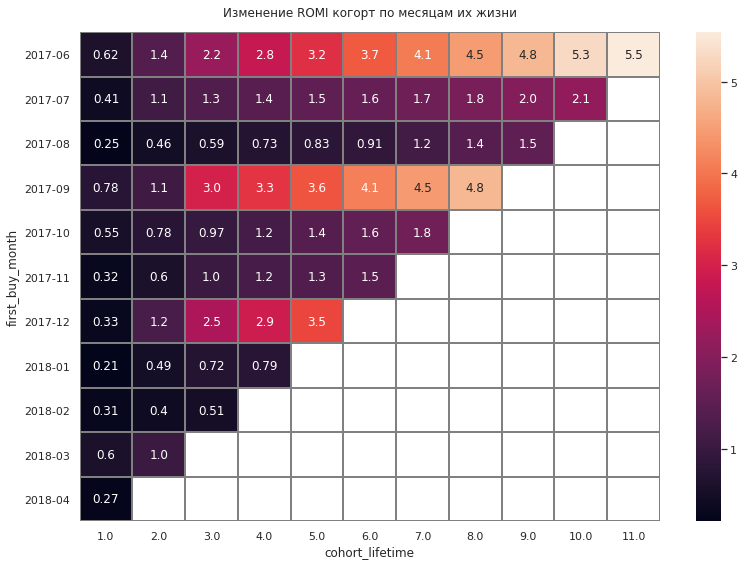

In [109]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Изменение ROMI когорт по месяцам их жизни', y=1.02)
sns.heatmap(romi_pivot_cohorts.cumsum(axis=1).round(2), annot=True, fmt='.2',\
            linewidths=1, linecolor='gray'); 

На тепловой карте мы видим, что на третий месяц жизни когорты коэффициент ROMI некоторых когорт принимает значение 1, но средний ROMI достигает единицы только на четвертый месяц. Это значит, что первые 3 месяца жизни когорты маркетинговые затраты не окупаются.

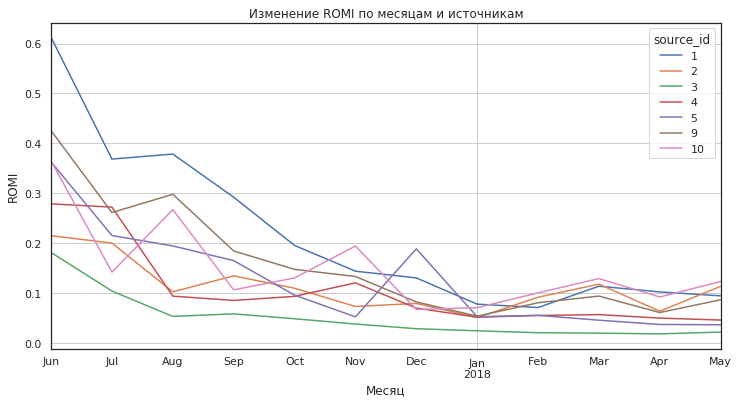

In [110]:
my_plot(romi_pivot_source, 'Изменение ROMI по месяцам и источникам', 'Месяц', 'ROMI')

На графике видно, что окупаемость по всем источникам меняется одинаково. Самая высокая окупаемость у источника 1, а самая низкая - у источника 3.

device
desktop    0.19
touch      0.05
dtype: float64


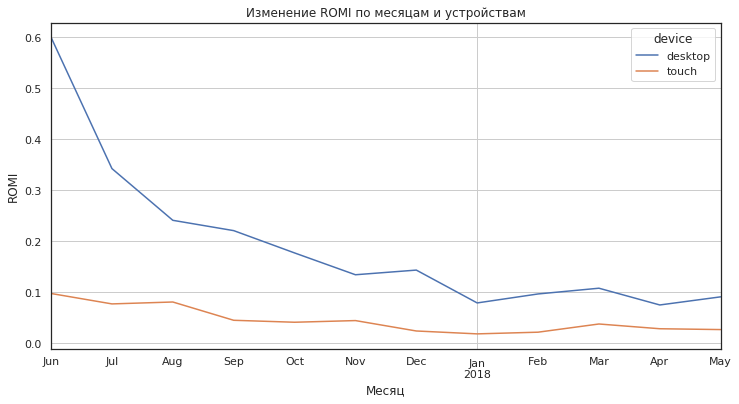

In [111]:
my_plot(romi_pivot_device, 'Изменение ROMI по месяцам и устройствам', 'Месяц', 'ROMI')
print(round(romi_pivot_device.mean(),2))

ROMI для ПК выше, чем для мобильных устройств. Значит привлечение этих клиентов более выгодно для компании.

Построим тепловую карту, чтобы оценить окупаемость источников.

In [112]:
romi_1['buy_month'] = romi_1['buy_month'].dt.strftime('%Y-%m')

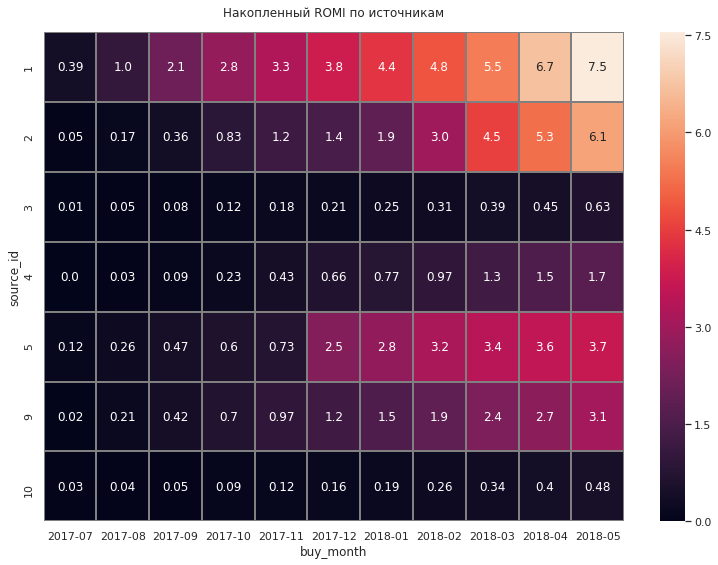

In [113]:
romi_pivot_source_ = romi_1.pivot_table(
    index='buy_month',
    columns='source_id',
    values='romi',
    aggfunc='sum',
).round(2).cumsum(axis=0)

sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Накопленный ROMI по источникам', y=1.02)
sns.heatmap(romi_pivot_source_.T, annot=True, fmt='.2',\
            linewidths=1, linecolor='gray');

На карте видно, что лучше всего окупается источник 1, за ним следует 2 и 5. Источники 3 и 10 не окупаются. Источники 4, 5 и 9 можно рассматривать на долгосрочную персективу.

Посмотрим на изменения ROMI по когортам для каждого источника.

Создадим список источников для загрузки в цикл.

In [114]:
source_dict = df_costs['source_id'].value_counts().sort_index().to_dict()
source_list = source_dict.keys()
display(source_list)

dict_keys([1, 2, 3, 4, 5, 9, 10])

Построим тепловые карты для изменения ROMI когорт для каждого источника с помощью цикла.

Накопленный ROMI по источнику 1 cohort_lifetime
0.0     0.89
1.0     1.05
2.0     1.24
3.0     1.30
4.0     1.42
5.0     1.55
6.0     1.73
7.0     1.91
8.0     2.20
9.0     2.59
10.0    3.22
11.0    4.22
dtype: float64
Накопленный ROMI по источнику 2 cohort_lifetime
0.0     0.55
1.0     0.61
2.0     0.76
3.0     0.93
4.0     1.08
5.0     1.24
6.0     0.91
7.0     0.97
8.0     0.98
9.0     0.82
10.0    1.06
11.0    1.21
dtype: float64
Накопленный ROMI по источнику 3 cohort_lifetime
0.0     0.34
1.0     0.36
2.0     0.37
3.0     0.38
4.0     0.39
5.0     0.41
6.0     0.41
7.0     0.42
8.0     0.42
9.0     0.40
10.0    0.45
11.0    0.44
dtype: float64
Накопленный ROMI по источнику 4 cohort_lifetime
0.0     0.76
1.0     0.77
2.0     0.79
3.0     0.80
4.0     0.82
5.0     0.87
6.0     0.92
7.0     0.83
8.0     0.81
9.0     0.82
10.0    0.99
11.0    1.10
dtype: float64
Накопленный ROMI по источнику 5 cohort_lifetime
0.0     0.66
1.0     0.71
2.0     0.76
3.0     0.99
4.0     1.07
5.0     1.1

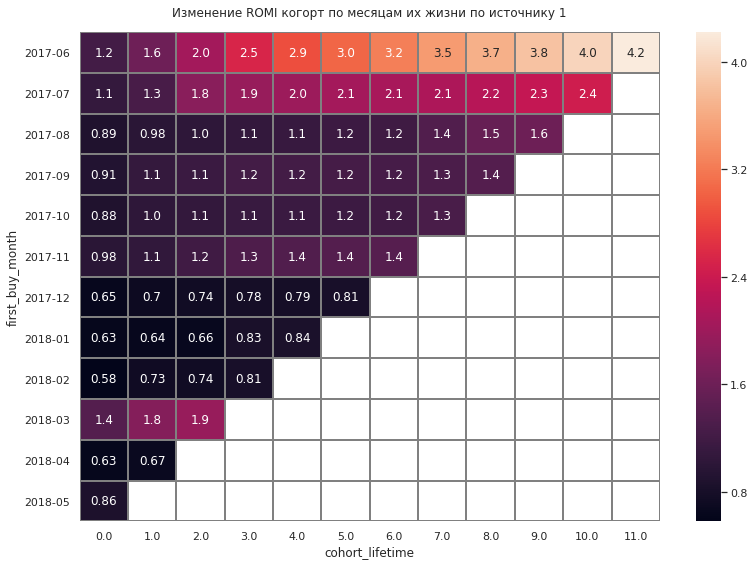

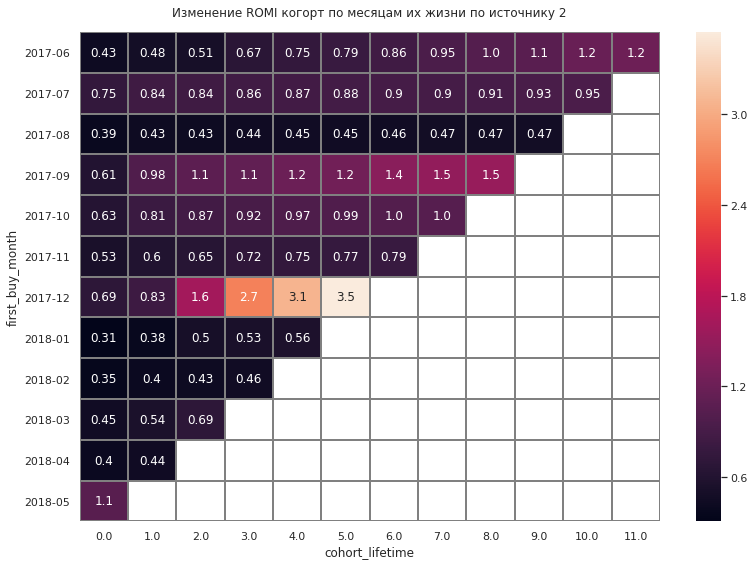

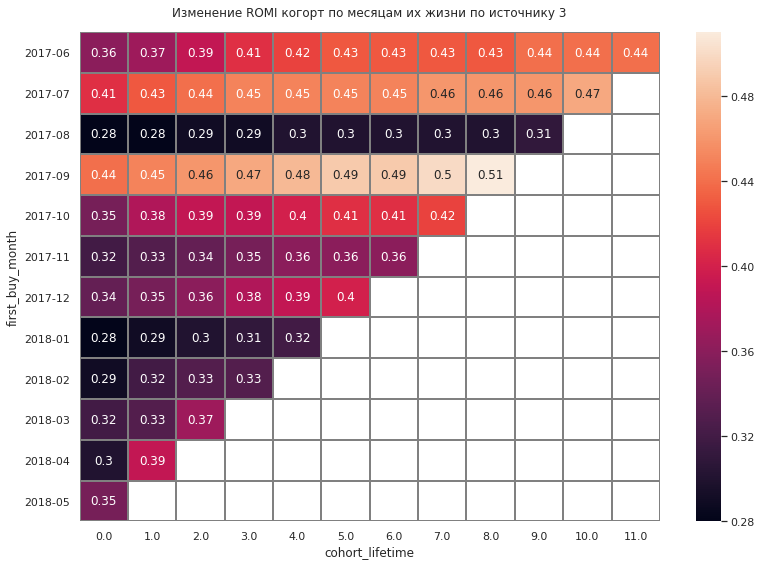

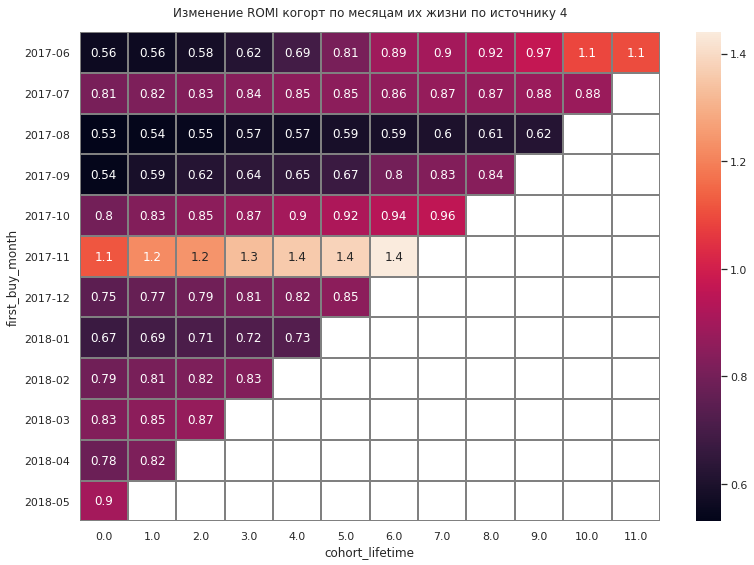

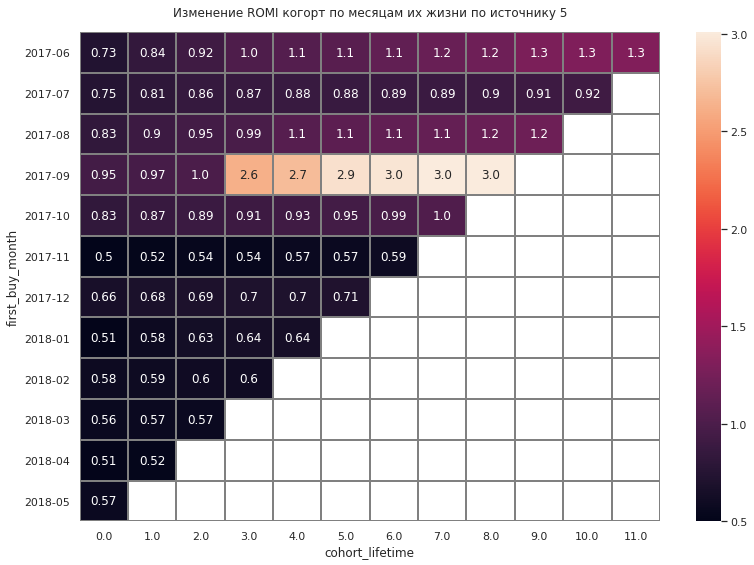

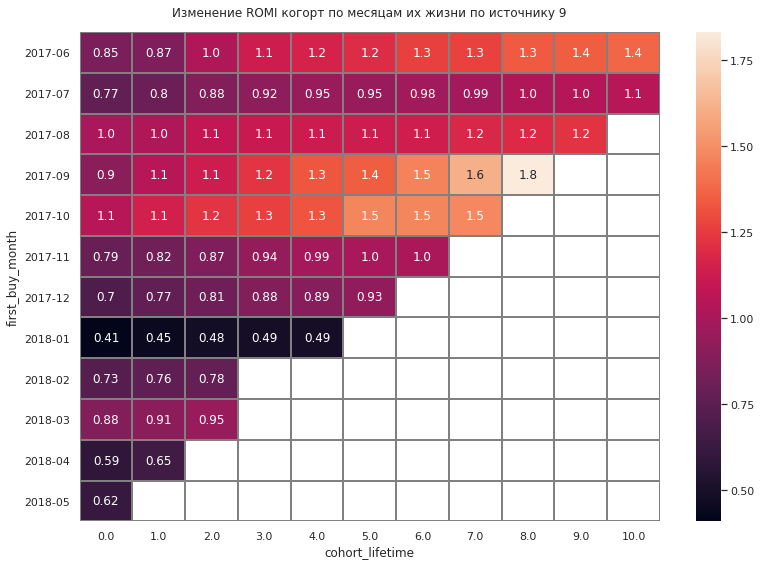

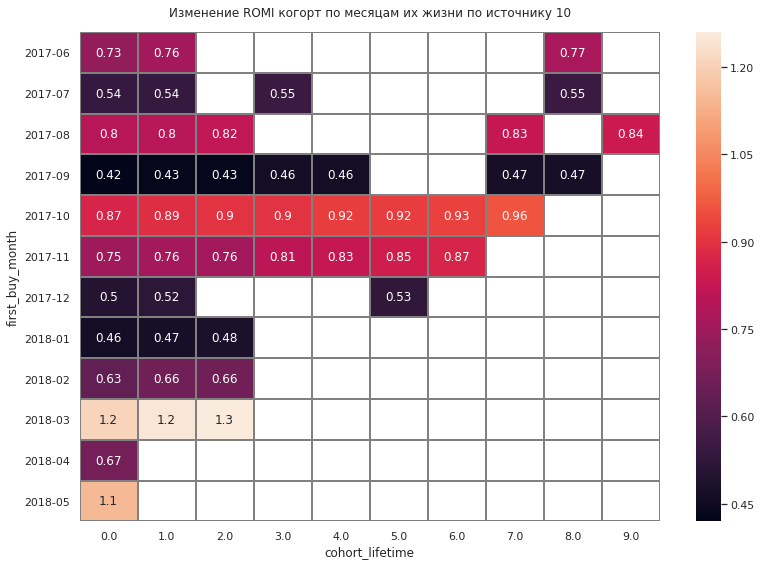

In [115]:
for i in source_list:
    df_orders_source_1 = df_orders_source[df_orders_source['source_id'] == i]
    df_orders_source_1['first_buy_month'] = df_orders_source_1['first_buy_month'].dt.strftime('%Y-%m')
    orders_source_group_1 = df_orders_source_1.groupby(['first_buy_month','buy_month','cohort_lifetime','source_id'])\
                    .agg({'user_id':'nunique','revenue':'sum'}).reset_index()
    orders_source_group_1.rename(columns={'user_id':'n_buyers'}, inplace=True)
    romi_source_1 = pd.merge(orders_source_group_1, source_costs_,\
                    left_on=['source_id', 'buy_month'],right_on=['source_id','costs_month'])
    romi_source_1['ltv'] = romi_source_1['revenue'] / romi_source_1['n_buyers']
    romi_source_1['cac'] = romi_source_1['costs'] / romi_source_1['n_buyers']
    romi_source_1['romi'] = romi_source_1['ltv'] / romi_source_1['cac']
    
    romi_cohorts_source_1 = romi_source_1.pivot_table(
                    index='first_buy_month',
                    columns='cohort_lifetime',
                    values='romi',
                    aggfunc='sum',
                    ).cumsum(axis=1).round(2);

    print('Накопленный ROMI по источнику '+str(i),romi_cohorts_source_1.mean().round(2));
    
    sns.set(style='white')
    plt.figure(figsize=(13, 9))
    plt.title('Изменение ROMI когорт по месяцам их жизни по источнику '+str(i), y=1.02)
    sns.heatmap(romi_cohorts_source_1, annot=True, fmt='.2', linewidths=1, linecolor='gray');

Когортный анализ ROMI по источникам показал __на каком месяце жизни в среднем наступает окупаемость когорт__ (отдельные когорты окупаются быстрее):
* источник 1 - на 2м месяце (самые сильные когорты - июнь, июль и март), накопленный ROMI - 4,22 у.е.;
* источник 2 - на 5м месяце (самые сильные когорты - декабрь, сентябрь и июнь), накопленный ROMI - 1,21 у.е.;
* источник 3 - не окупается, накопленный ROMI - 0,44 у.е.;
* источник 4 - на 12м месяце (самые сильные когорты - ноябрь и июнь), накопленный ROMI - 1,1 у.е.;
* источник 5 - на 5м месяце (самые сильные когорты - сентябрь и июнь), накопленный ROMI - 1,32 у.е.;
* источник 9 - на 4 месяце (самые сильные когорты - сентябрь, октябрь и июнь), накопленный ROMI - 1,21 у.е.;
* источник 10 - не окупается, накопленный ROMI - 0,84 у.е.

#### Вывод

Наиболее затратным для компании является источник №3, его затраты значительно превышают затраты других источников. Также мы видим начало увеличения затрат в сенятбре 2017г. В это время на сайт приходит самая прибыльная когорта.

В ноябре затраты достигают пиковых значений (по всем источникам, кроме №4). Скорее всего это связано с привлечением покупателей на предновогодние распродажи. И в декабре мы видели результат - увеличение среднего чека и ltv.

Стоимость привлечения одного клиента: 9.01 у.е. 
Привлечение клиентов по источникам 2 и 3 обходится дороже. Меньше всего компания тратит на привлечение по источнику 9. Наблюдается 3 сезонных пика - август, ноябрь и январь.

Самые большие значения принимает ROMI сентябрьской когорты. На втором месте - декабрьская когорта.
Маркетинговые затраты окупаются на четвертый месяц жизни когорты. 
ROMI для ПК выше, чем для мобильных устройств. Значит привлечение этих клиентов более выгодно для компании.

Самая высокая окупаемость у источников 1,5,2 и 9, а источники 3 и 10 не окупаются.

## Шаг 4. Общий вывод

<div style="border:solid Green 2px; padding: 40px">
    
* На основании коэфицииента ROMI самым окупаемым источником является №1. Источник №3 сейчас самый затратный, при этом окупаемость по нему самая низкая, стоит сократить затраты по этому источнику.

* Среднее число уникальных пользователей стабильное высокое: 907 в день, 5716 в неделю, 23228 в месяц, а значения фактора липкости для недели и месяца минимальны. Значит, пользователи редко возвращаются на сайт. 
Средняя продолжительность сессии всего 60 секунд и каждый покупатель совершает в среднем 1 заказ.
При планировании маркетинговых активностей нужно делать упор не на привлечение, а на удержанием аудитории (скидки для повторных покупателей, рассылки с таргетированными подборками, реклама подобных предложений на сайте в момент просмотра страницы с мероприятием).

* Анализ типа устройства показывает, что аудитория ПК-версии сайта в 2.5 раза больше, чем мобильной. Коэффициент удержания и окупаемость затрат на ПК тоже выше. Возможно, мобильная версия менее удобна. Продолжительность сессии на ПК больше, чем на мобильных устройствах, это может быть связано с размером заказа, средний чек для ПК больше.

* LTV за год: 6.9 у.е., средний чек: 4.96 у.е., а стоимость привлечения одного клиента: 9.01 у.е. Когортный анализ показал окупаемость на четвертом месяце жизни. 

* Самая окупаемая когорта - сентябрьская, также у нее самый высокий коэффициент удержания. Следующая по окупаемости - декабрьская. Вероятно, это связано с сезонностью, в начале осени интерес пользователей увеличивается.

* __Рекомендуется расставить приоритеты в бюджетировании источников трафика следующим образом:__
    1. источник 1 (выгоднее привлекать в июне, июле и марте);
    2. источник 5 (выгоднее привлекать в сентябре и июне);
    3. источник 2 (выгоднее привлекать в декабре, сентябре и июне);
    5. источник 9 (выгоднее привлекать в сентябре, октябре и июне); 
    4. источник 4 можно рассматривать на долгосрочную персективу (выгоднее привлекать в ноябре и июне);
    5. источники 3 и 10 перестать финансировать.
</div>